In [195]:
import ssm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [3]:
# get all 39 sessions
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
                              
alldat.shape

(39,)

In [4]:
dat = alldat[11]   # a dict
print('keys:', len(dat.keys()), dat.keys())

print('')
print('mouse_name:', dat['mouse_name'])
print('date_exp:', dat['date_exp'])
print('brain_area:', dat['brain_area'].shape, np.unique(dat['brain_area']))

print('')
print('bin_size:', dat['bin_size'])
print('stim_onset:', dat['stim_onset'])
print('spks(neurons*trials*time_bins):', dat['spks'].shape, np.unique(dat['spks']))

print('')
print('gocue:', dat['gocue'].shape)
print('contrast_right:', dat['contrast_right'].shape, np.unique(dat['contrast_right']))
print('contrast_left:', dat['contrast_left'].shape, np.unique(dat['contrast_left']))
print('feedback_time:', dat['feedback_time'].shape)
print('feedback_type:', dat['feedback_type'].shape, np.unique(dat['feedback_type']))
print('response_time:', dat['response_time'].shape)
print('response:', dat['response'].shape, np.unique(dat['response']))

print('')
print('active_trials:', dat['active_trials'].shape)
print('reaction_time:', dat['reaction_time'].shape)

print('')
print('pupil:', dat['pupil'].shape)
print('wheel:', dat['wheel'].shape)

keys: 31 dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

mouse_name: Lederberg
date_exp: 2017-12-05
brain_area: (698,) ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']

bin_size: 0.01
stim_onset: 0.5
spks(neurons*trials*time_bins): (698, 340, 250) [0 1 2 3 4 5 6]

gocue: (340, 1)
contrast_right: (340,) [0.   0.25 0.5  1.  ]
contrast_left: (340,) [0.   0.25 0.5  1.  ]
feedback_time: (340, 1)
feedback_type: (340,) [-1.  1.]
response_time: (340, 1)
response: (340,) [-1.  0.  1.]

active_trials: (450,)
reaction_time: (340, 2)

pupil: (3, 340, 250)
wheel: (1

In [5]:
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']

# stim_onset = int(stim_onset/bin_size)
# response_time = response_time/bin_size

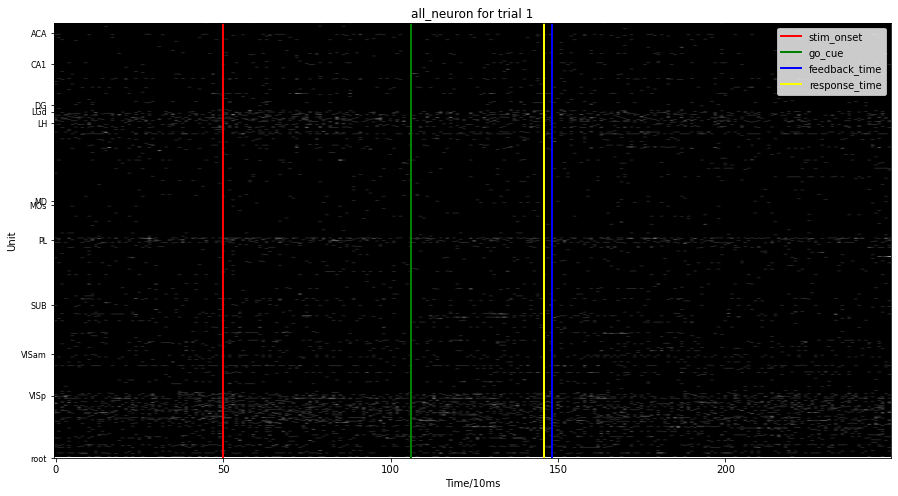

In [8]:
# Display a spike raster of the image

n_trial = 1

plt.figure(figsize=(15,8))
plt.imshow(neural_activity[:,n_trial,:], aspect='auto', cmap='gray')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = neural_activity.shape[2]

plt.axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
plt.axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
plt.axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
plt.axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
plt.ylabel("Unit")
plt.xlabel("Time/10ms")

unique, count=np.unique(brain_areas,return_counts=True)
yticklabels = unique
yticklabels_idx = np.cumsum(count)
plt.yticks(yticklabels_idx, yticklabels, fontsize=8)
plt.legend()
plt.tight_layout
plt.title(f'all_neuron for trial {n_trial}')
plt.show()

LP: -20144.9: 100%|██████████| 100/100 [00:01<00:00, 63.74it/s]


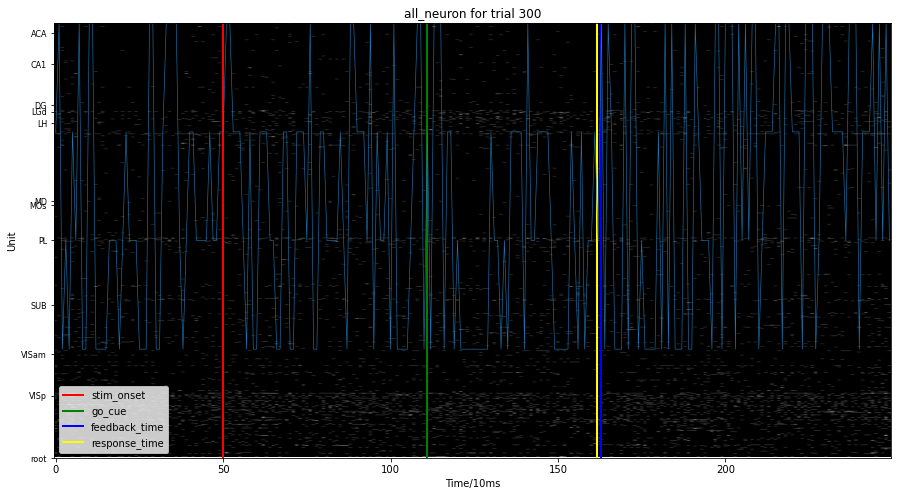

In [55]:
# Display a spike raster of the image

def raster_trial(neural_activity, n_trial, stim_onset, gocue, feedback_time, response_time, bin_size, brain_areas):

    plt.figure(figsize=(15,8))
    plt.imshow(neural_activity[:,n_trial,:], aspect='auto', cmap='gray')
    #plt.axis('off')

    # Label the different phases of the trial movement activity
    time_bins = neural_activity.shape[2]

    plt.axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    plt.axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
    plt.axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
    plt.axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
    plt.ylabel("Unit")
    plt.xlabel("Time/10ms")
    plt.legend()

    num_states = 4
    num_neurons = neural_activity.shape[0]
    neural_activity_try = neural_activity[:, n_trial, :]
    test_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    test_hmm.fit(neural_activity_try.T)
    zhat = test_hmm.most_likely_states(neural_activity_try.T)

    plt.plot(zhat/4*neural_activity.shape[0], linewidth=0.6)

    unique, count=np.unique(brain_areas,return_counts=True)
    yticklabels = unique
    yticklabels_idx = np.cumsum(count)
    plt.yticks(yticklabels_idx, yticklabels, fontsize=8)

    plt.tight_layout
    plt.title(f'all_neuron for trial {n_trial}')
    plt.show()

n_trial = 300
raster_trial(neural_activity, 300, stim_onset, gocue, feedback_time, response_time, bin_size, brain_areas)

In [57]:
unique, count=np.unique(brain_areas,return_counts=True)
data_count=dict(zip(unique,count))
data_count
print(unique, count)

['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root'] [ 16  50  65  11  18 126   6  56 105  79  66 100]


# different brain areas

In [58]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

np.unique(barea, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([145, 155, 220,  78, 100], dtype=int64))

LP: -2732.7: 100%|██████████| 500/500 [00:01<00:00, 372.82it/s]


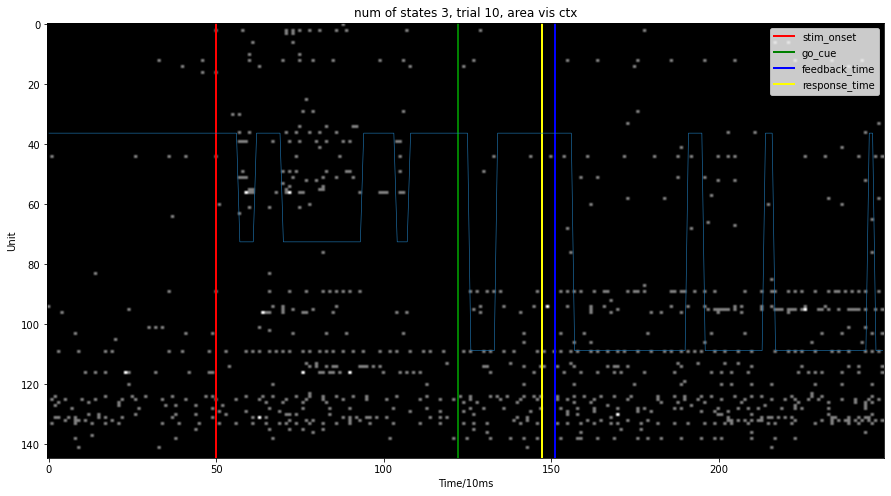

LP: -9685.0: 100%|██████████| 500/500 [00:01<00:00, 354.61it/s]


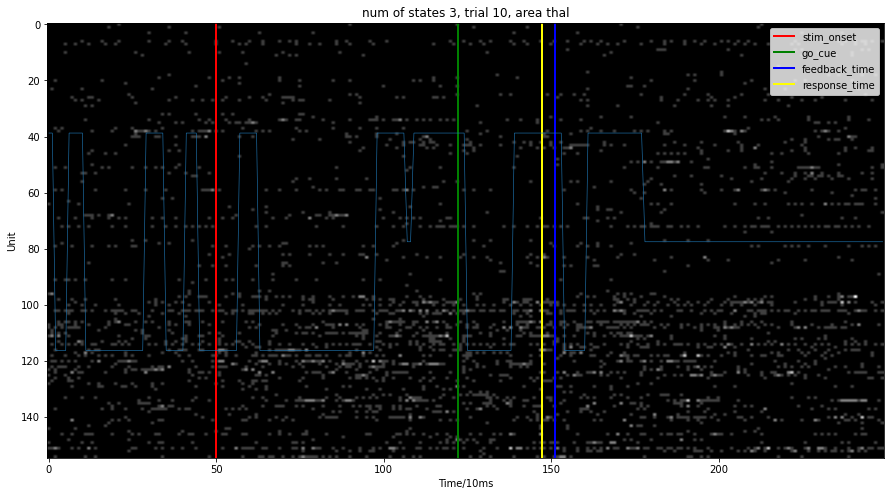

LP: -7697.1: 100%|██████████| 500/500 [00:02<00:00, 216.80it/s]


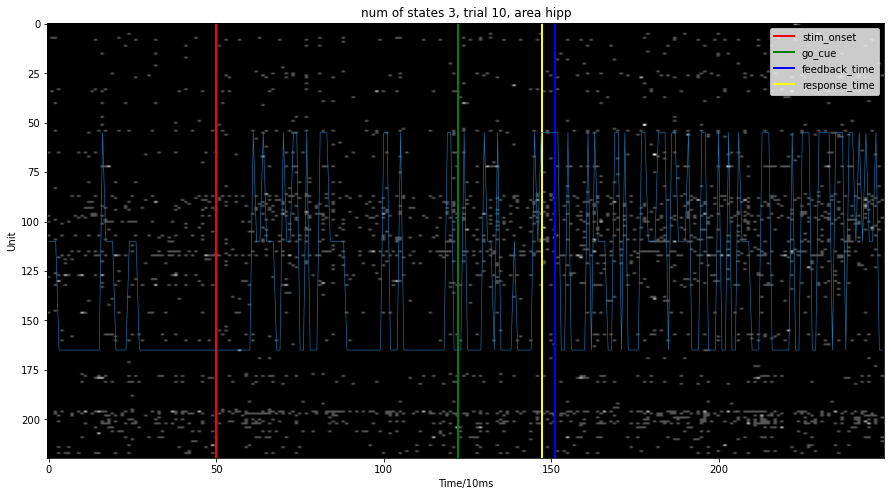

LP: -612.9: 100%|██████████| 500/500 [00:00<00:00, 509.45it/s]


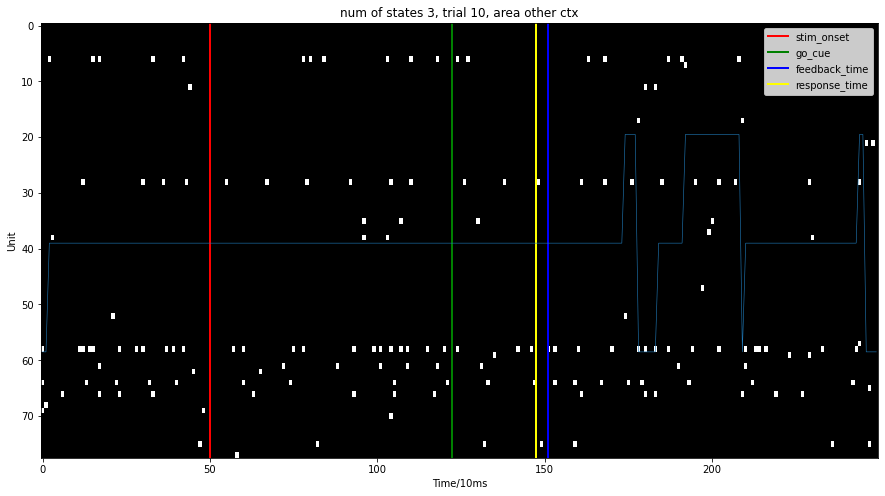

In [83]:
n_trial = 10

for i in range(nareas):

    neural_activity_area = neural_activity[barea==i]

    plt.figure(figsize=(15,8))
    plt.imshow(neural_activity_area[:,n_trial,:], aspect='auto', cmap='gray')
    #plt.axis('off')

    # Label the different phases of the trial movement activity
    time_bins = neural_activity_area.shape[2]

    plt.axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    plt.axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
    plt.axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
    plt.axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
    plt.ylabel("Unit")
    plt.xlabel("Time/10ms")
    plt.legend()

    num_states = 3
    num_neurons = neural_activity_area.shape[0]
    neural_activity_try = neural_activity_area[:, n_trial, :]
    test_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    test_hmm.fit(neural_activity_try.T, method="em", num_iters = 500)
    zhat = test_hmm.most_likely_states(neural_activity_try.T)

    plt.plot((zhat+1)/(num_states+1)*neural_activity_area.shape[0], linewidth=0.6)

    plt.tight_layout
    plt.title(f'num of states {num_states}, trial {n_trial}, area {regions[i]}')
    plt.show()

LP: -2732.4: 100%|██████████| 100/100 [00:00<00:00, 246.96it/s]


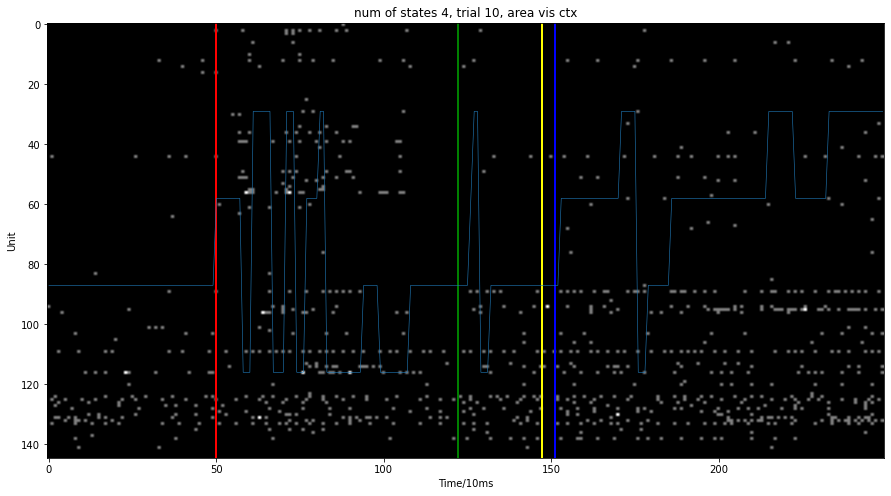

LP: -9613.0: 100%|██████████| 100/100 [00:00<00:00, 231.20it/s]


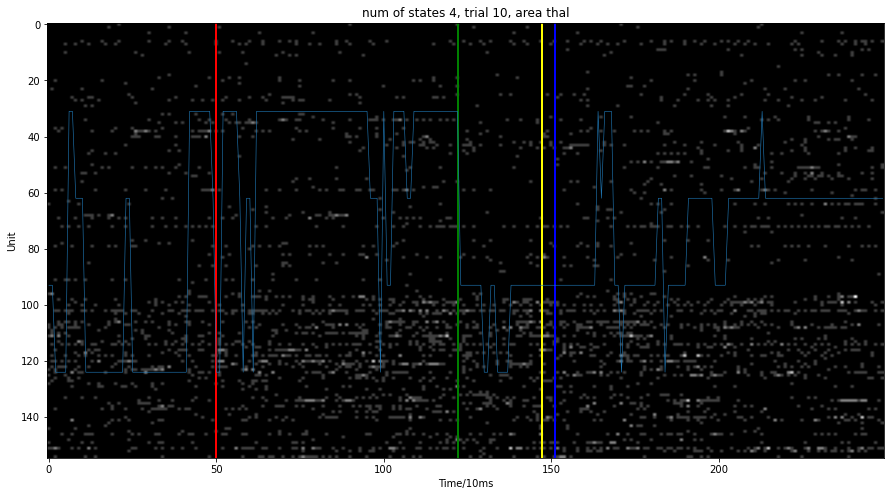

LP: -7591.3: 100%|██████████| 100/100 [00:00<00:00, 180.66it/s]


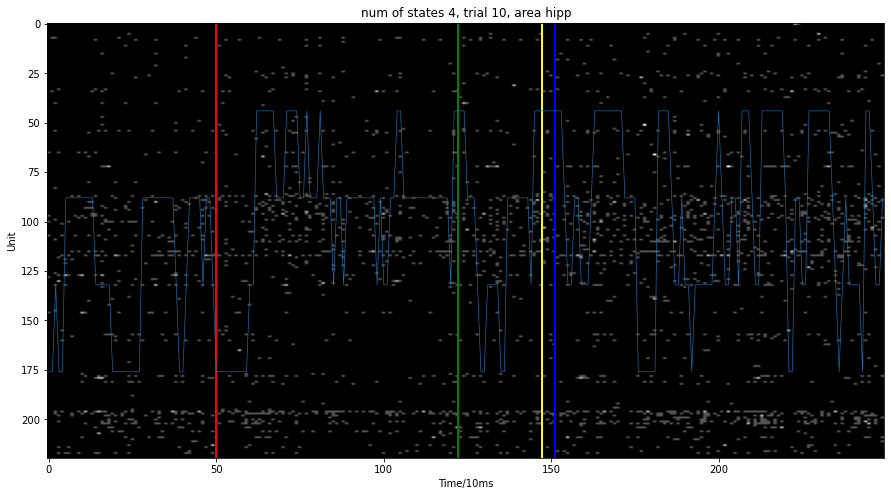

LP: -605.1: 100%|██████████| 100/100 [00:00<00:00, 392.28it/s]


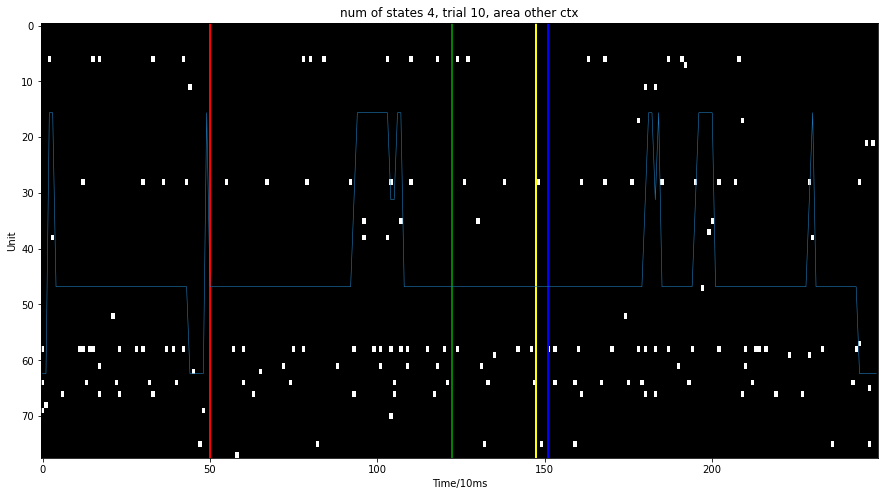

In [103]:
for i in range(nareas):

    neural_activity_area = neural_activity[barea==i]

    plt.figure(figsize=(15,8))
    plt.imshow(neural_activity_area[:,n_trial,:], aspect='auto', cmap='gray')

    plt.axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    plt.axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
    plt.axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
    plt.axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
    plt.ylabel("Unit")
    plt.xlabel("Time/10ms")

    num_states = 4
    num_neurons = neural_activity_area.shape[0]
    neural_activity_try = neural_activity_area[:, n_trial, :]
    test_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    test_hmm.fit(neural_activity_try.T, method="em", num_iters = 100)
    zhat = test_hmm.most_likely_states(neural_activity_try.T)

    plt.plot((zhat+1)/(num_states+1)*neural_activity_area.shape[0], linewidth=0.6)

    plt.tight_layout
    plt.title(f'num of states {num_states}, trial {n_trial}, area {regions[i]}')
    plt.show()

# different trial types

In [101]:
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
vis_stim = vis_left - vis_right # right - nogo - left
# trials types by response
resp_left_id = response > 0
resp_no_id = response == 0
resp_right_id = response < 0
# trials types by visual stimuli
vis_left_id = vis_stim > 0
vis_no_id = vis_stim == 0
vis_right_id = vis_stim < 0
# trials types by result
correct_id_left = np.logical_and(vis_left > 0, response > 0)
orrect_id_no = np.logical_and(vis_left == 0, response == 0)
orrect_id_right = np.logical_and(vis_left < 0, response < 0)
correct_id = np.logical_or(correct_id_left, orrect_id_no, orrect_id_right)
incorrect_id = np.logical_not(correct_id)

resp_left

LP: -86921.9: 100%|██████████| 300/300 [00:46<00:00,  6.47it/s]


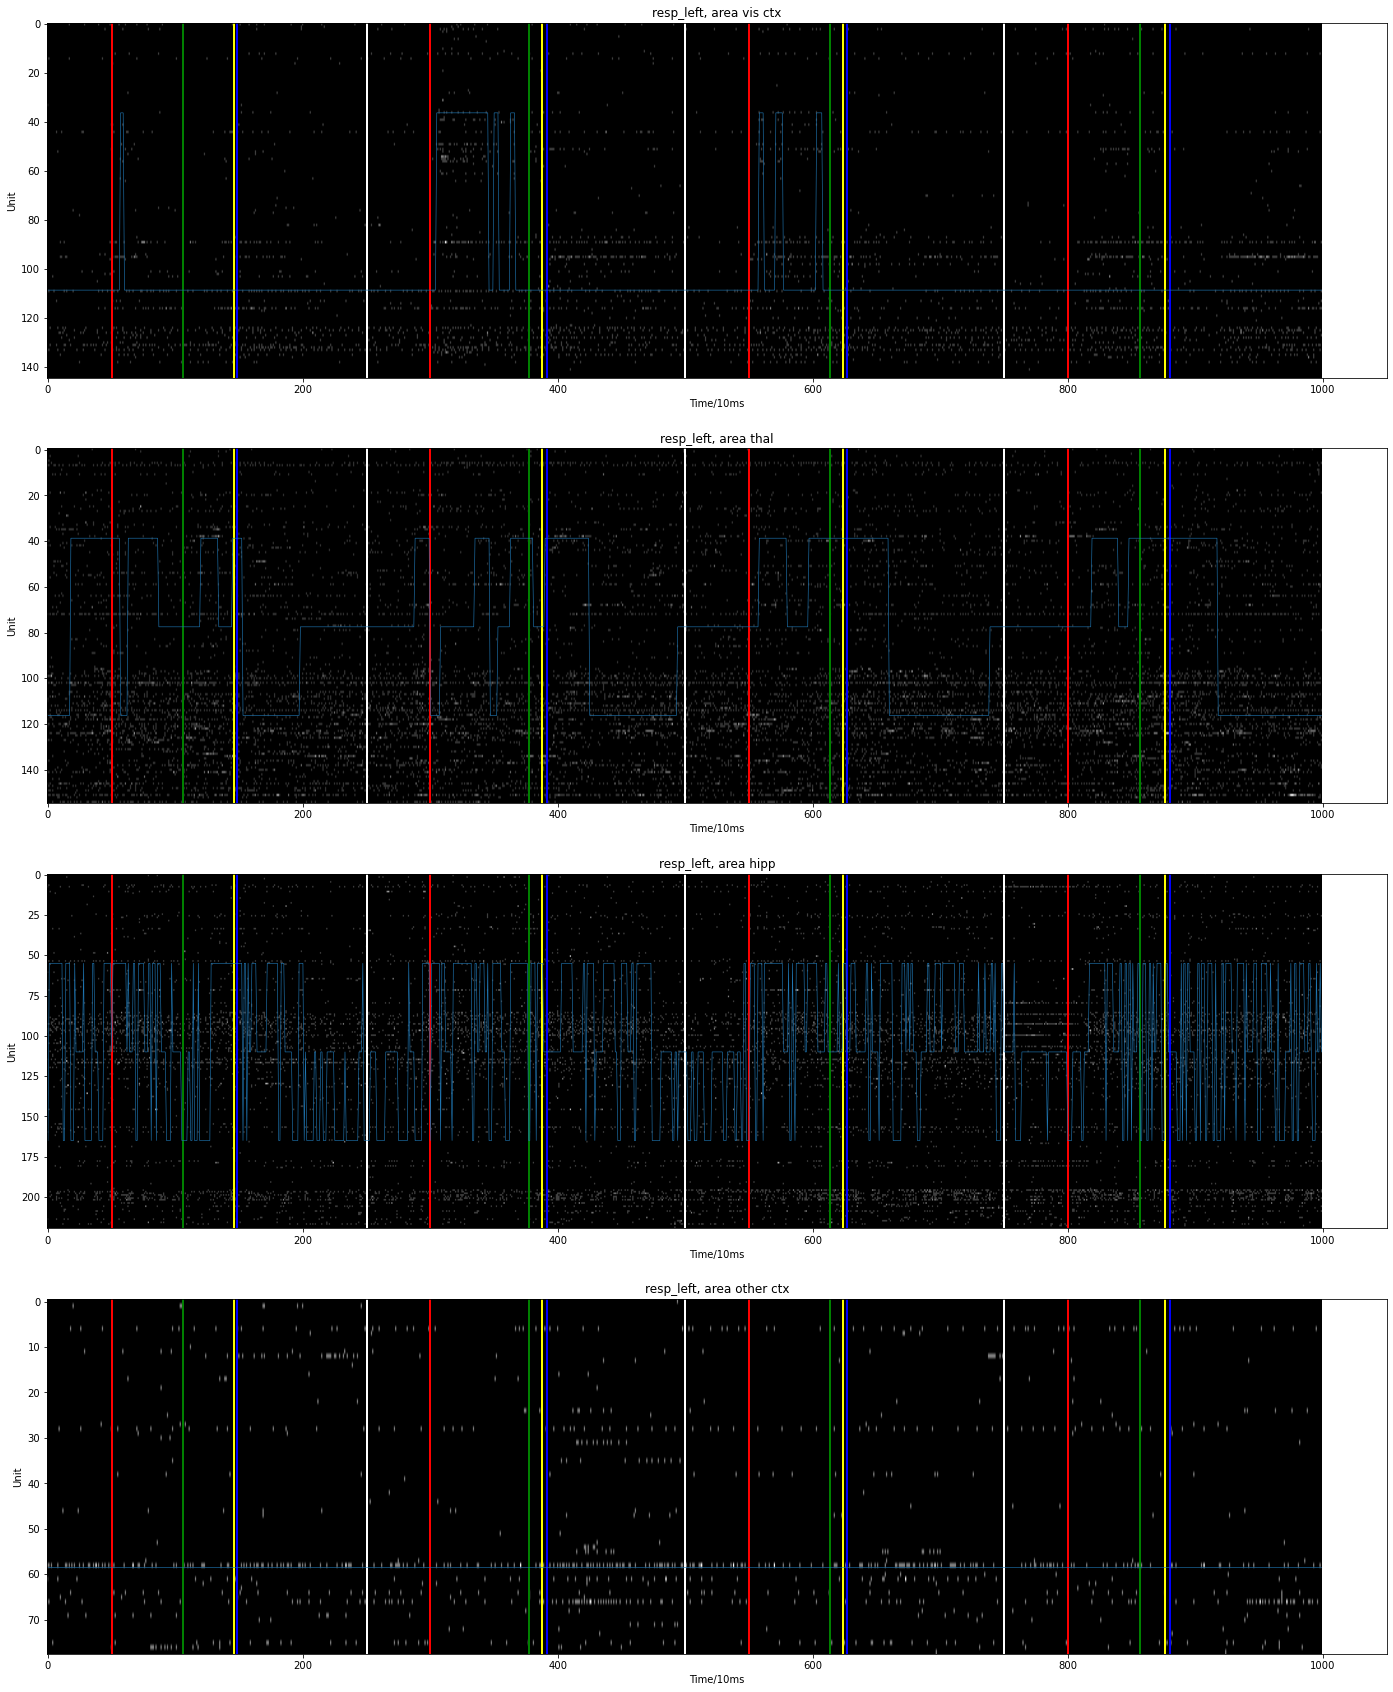

In [110]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 30))

for i in range(nareas):

    # resp_left
    neural_activity_resp_left = neural_activity[barea==i][:, resp_left_id, :]
    num_neurons = neural_activity_resp_left.shape[0]
    resp_left_input = neural_activity_resp_left.reshape(num_neurons, neural_activity_resp_left.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(resp_left_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(resp_left_input.T)
    
    resp_left_trial = resp_left_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(resp_left_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[resp_left_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[resp_left_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[resp_left_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*resp_left_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[0]}, area {regions[i]}')

plt.tight_layout
plt.show()

no_resp

LP: -46223.9: 100%|██████████| 300/300 [00:23<00:00, 12.93it/s]


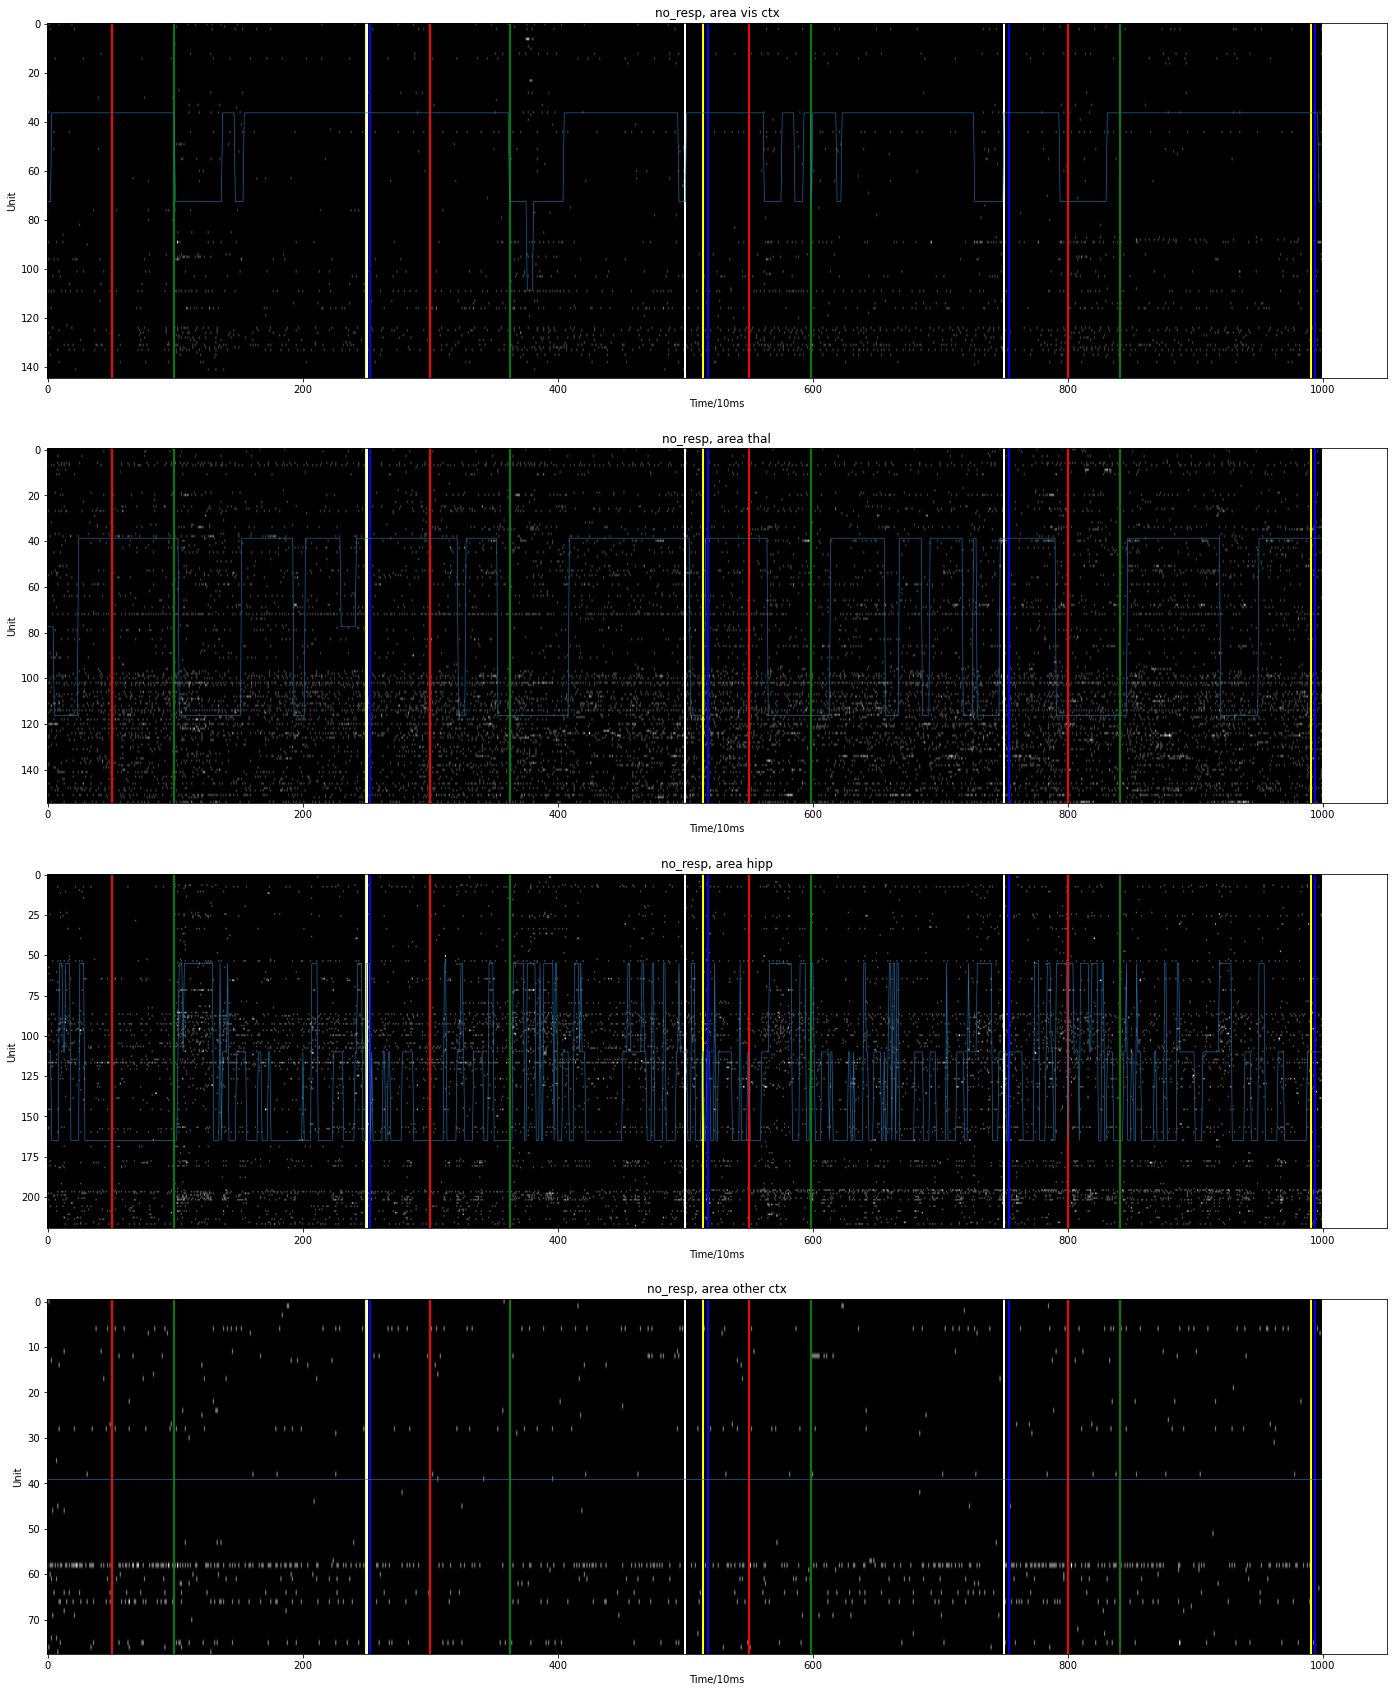

In [111]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 30))

for i in range(nareas):

    # resp_left
    neural_activity_resp_no = neural_activity[barea==i][:, resp_no_id, :]
    num_neurons = neural_activity_resp_no.shape[0]
    resp_no_input = neural_activity_resp_no.reshape(num_neurons, neural_activity_resp_no.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(resp_no_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(resp_no_input.T)
    
    resp_no_trial = resp_no_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(resp_no_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[resp_no_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[resp_no_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[resp_no_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*resp_no_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[1]}, area {regions[i]}')

plt.tight_layout
plt.show()

resp_right

LP: -91976.9: 100%|██████████| 300/300 [00:50<00:00,  5.99it/s]


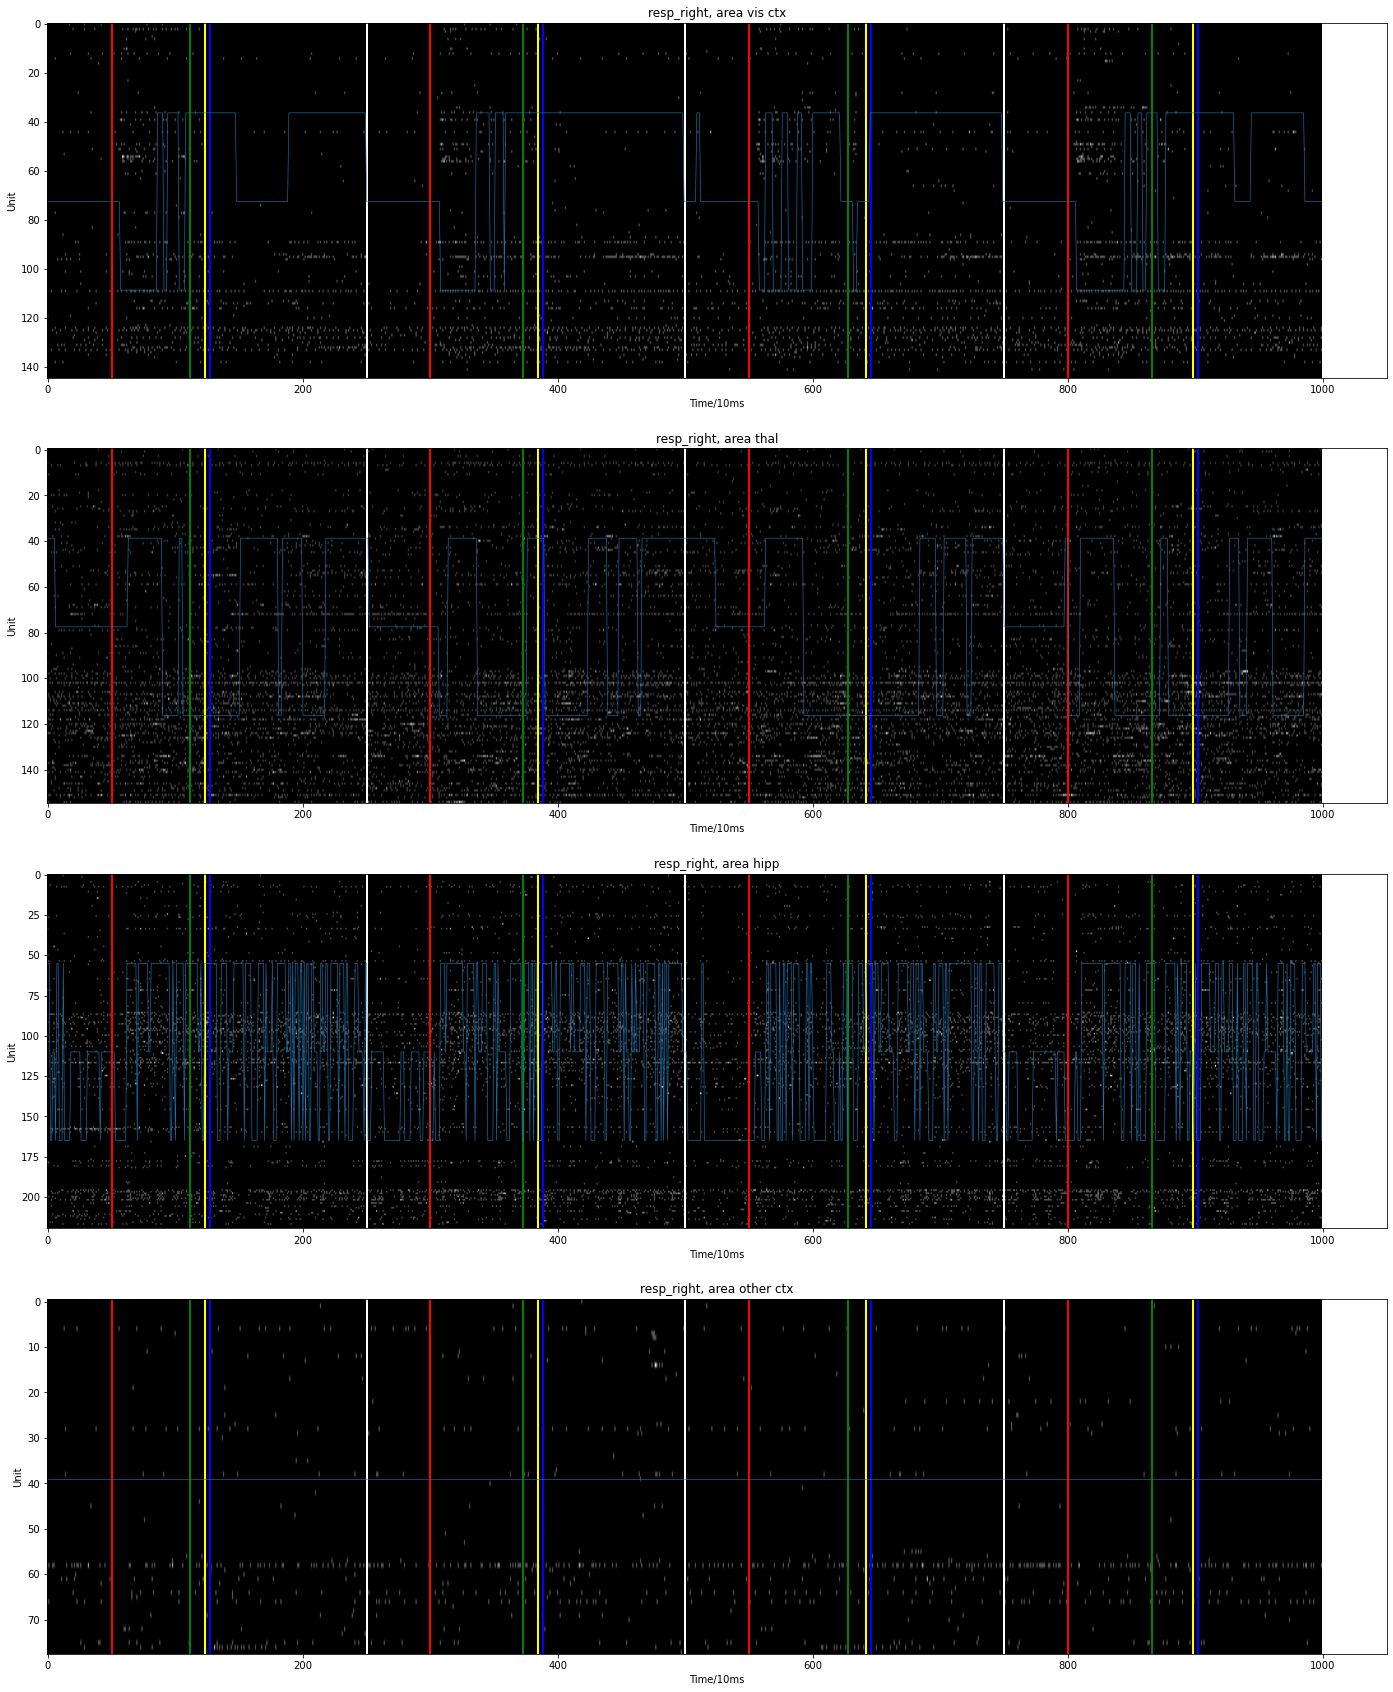

In [112]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 30))

for i in range(nareas):

    # resp_left
    neural_activity_resp_right = neural_activity[barea==i][:, resp_right_id, :]
    num_neurons = neural_activity_resp_right.shape[0]
    resp_right_input = neural_activity_resp_right.reshape(num_neurons, neural_activity_resp_right.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(resp_right_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(resp_right_input.T)
    
    resp_right_trial = resp_right_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(resp_right_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[resp_right_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[resp_right_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[resp_right_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*resp_right_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[2]}, area {regions[i]}')

plt.tight_layout
plt.show()

LP: -91067.6: 100%|██████████| 300/300 [00:53<00:00,  5.60it/s]


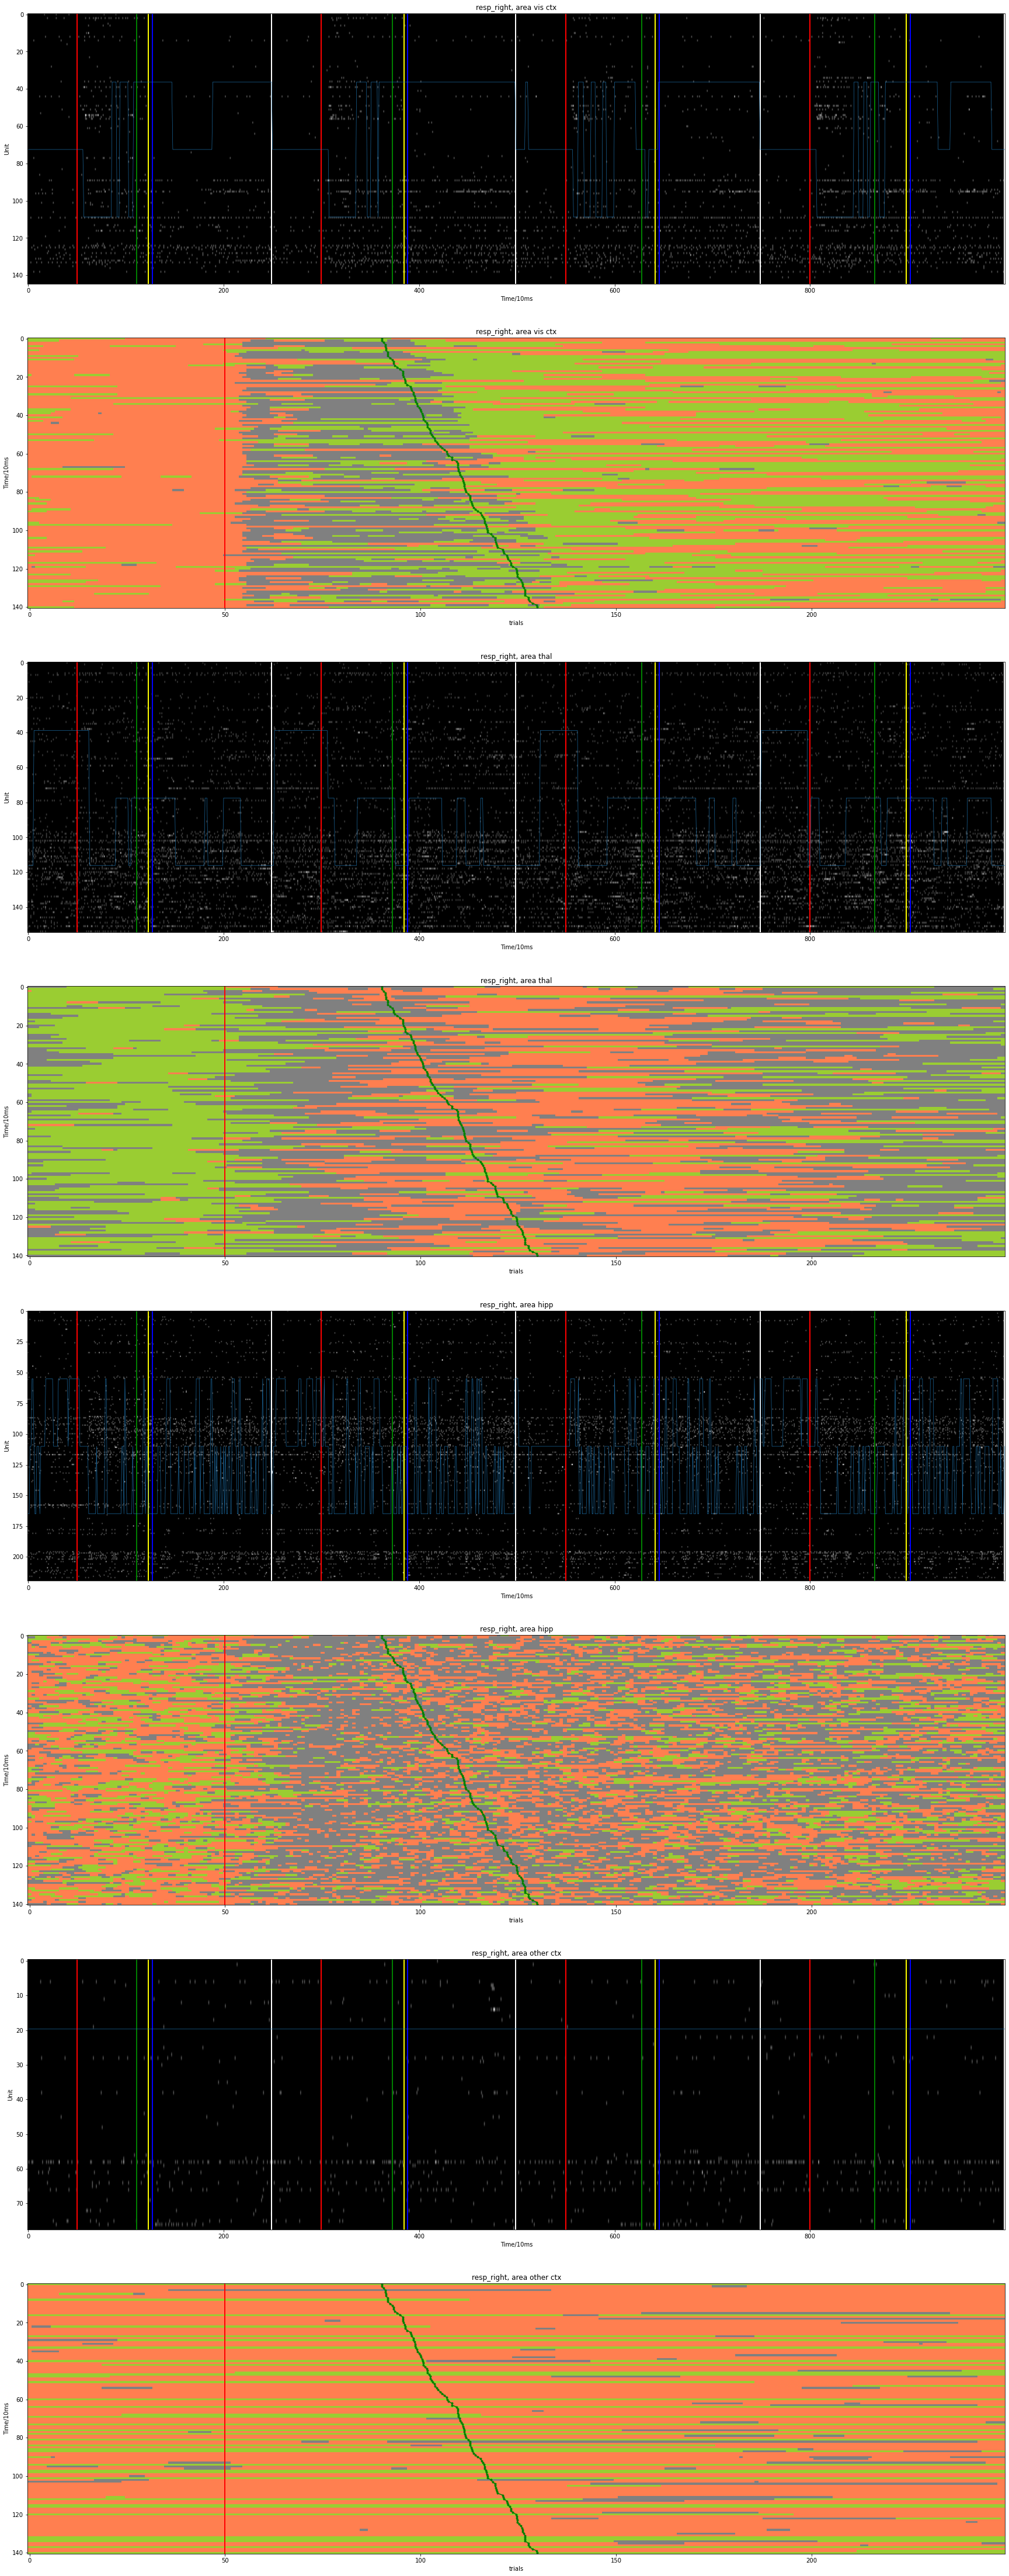

In [194]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=nareas*2, figsize=(30, 80))

for i in range(nareas):

    # resp_left
    neural_activity_resp_right = neural_activity[barea==i][:, resp_right_id, :]
    num_neurons = neural_activity_resp_right.shape[0]
    num_trials = neural_activity_resp_right.shape[1]
    resp_right_input = neural_activity_resp_right.reshape(num_neurons, num_trials*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(resp_right_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(resp_right_input.T)
    
    resp_right_trial = resp_right_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[2*i].imshow(resp_right_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[2*i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[2*i].axvline(x=gocue[resp_right_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[2*i].axvline(x=feedback_time[resp_right_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[2*i].axvline(x=response_time[resp_right_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[2*i].axvline(x=time_bins*(j+1)-1, color='white', linewidth=2, label='trial_time')

    axes[2*i].set_ylabel("Unit")
    axes[2*i].set_xlabel("Time/10ms")
    # axes[2*i+1].legend()
    axes[2*i].plot((states_seq_trial+1)/(num_states+1)*num_neurons, linewidth=0.6)
    axes[2*i].set_title(f'{trial_types[2]}, area {regions[i]}')

    states_mat = states_seq.reshape(num_trials, time_bins)
    go_cue_array = gocue[resp_right_id]/bin_size
    go_cue_array = go_cue_array.flatten()
    go_cue_idx = np.argsort(go_cue_array)

    go_cue_sorted = go_cue_array[go_cue_idx]
    states_mat_sorted = states_mat[go_cue_idx, :]

    cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
    axes[2*i+1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
    axes[2*i+1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    axes[2*i+1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
    # axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
    # axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
    axes[2*i+1].set_ylabel("Time/10ms")
    axes[2*i+1].set_xlabel("trials")
    axes[2*i+1].set_title(f'{trial_types[2]}, area {regions[i]}')

plt.tight_layout
plt.show()

vis_left

LP: -67565.5: 100%|██████████| 300/300 [00:37<00:00,  8.01it/s]


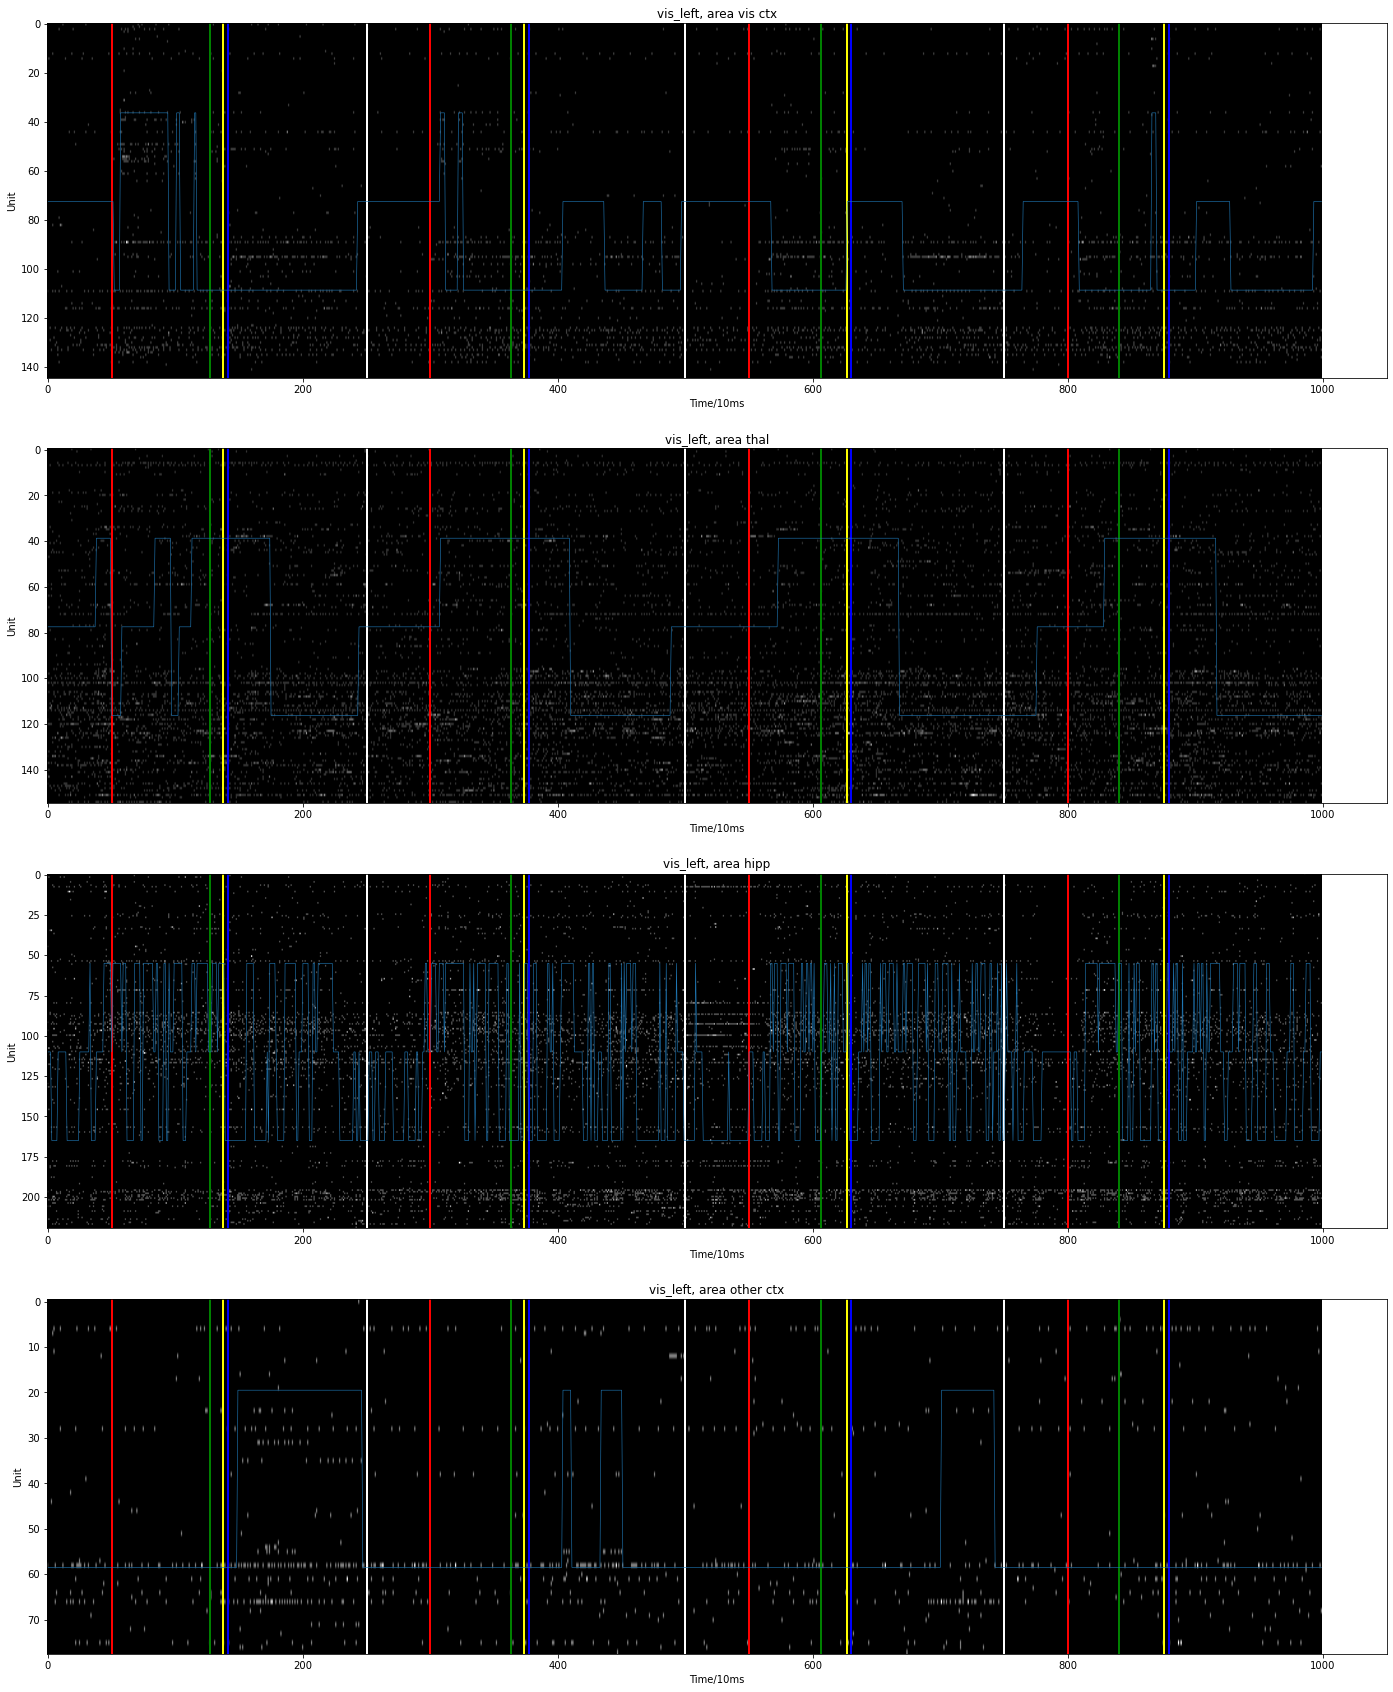

In [113]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['vis_left', 'no_vis', 'vis_right']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 30))

for i in range(nareas):

    neural_activity_vis_left = neural_activity[barea==i][:, vis_left_id, :]
    num_neurons = neural_activity_vis_left.shape[0]
    vis_left_input = neural_activity_vis_left.reshape(num_neurons, neural_activity_vis_left.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(vis_left_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(vis_left_input.T)
    
    vis_left_trial = vis_left_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(vis_left_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[vis_left_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[vis_left_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[vis_left_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*vis_left_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[0]}, area {regions[i]}')

plt.tight_layout
plt.show()

no_vis

LP: -77578.5: 100%|██████████| 300/300 [00:44<00:00,  6.81it/s]


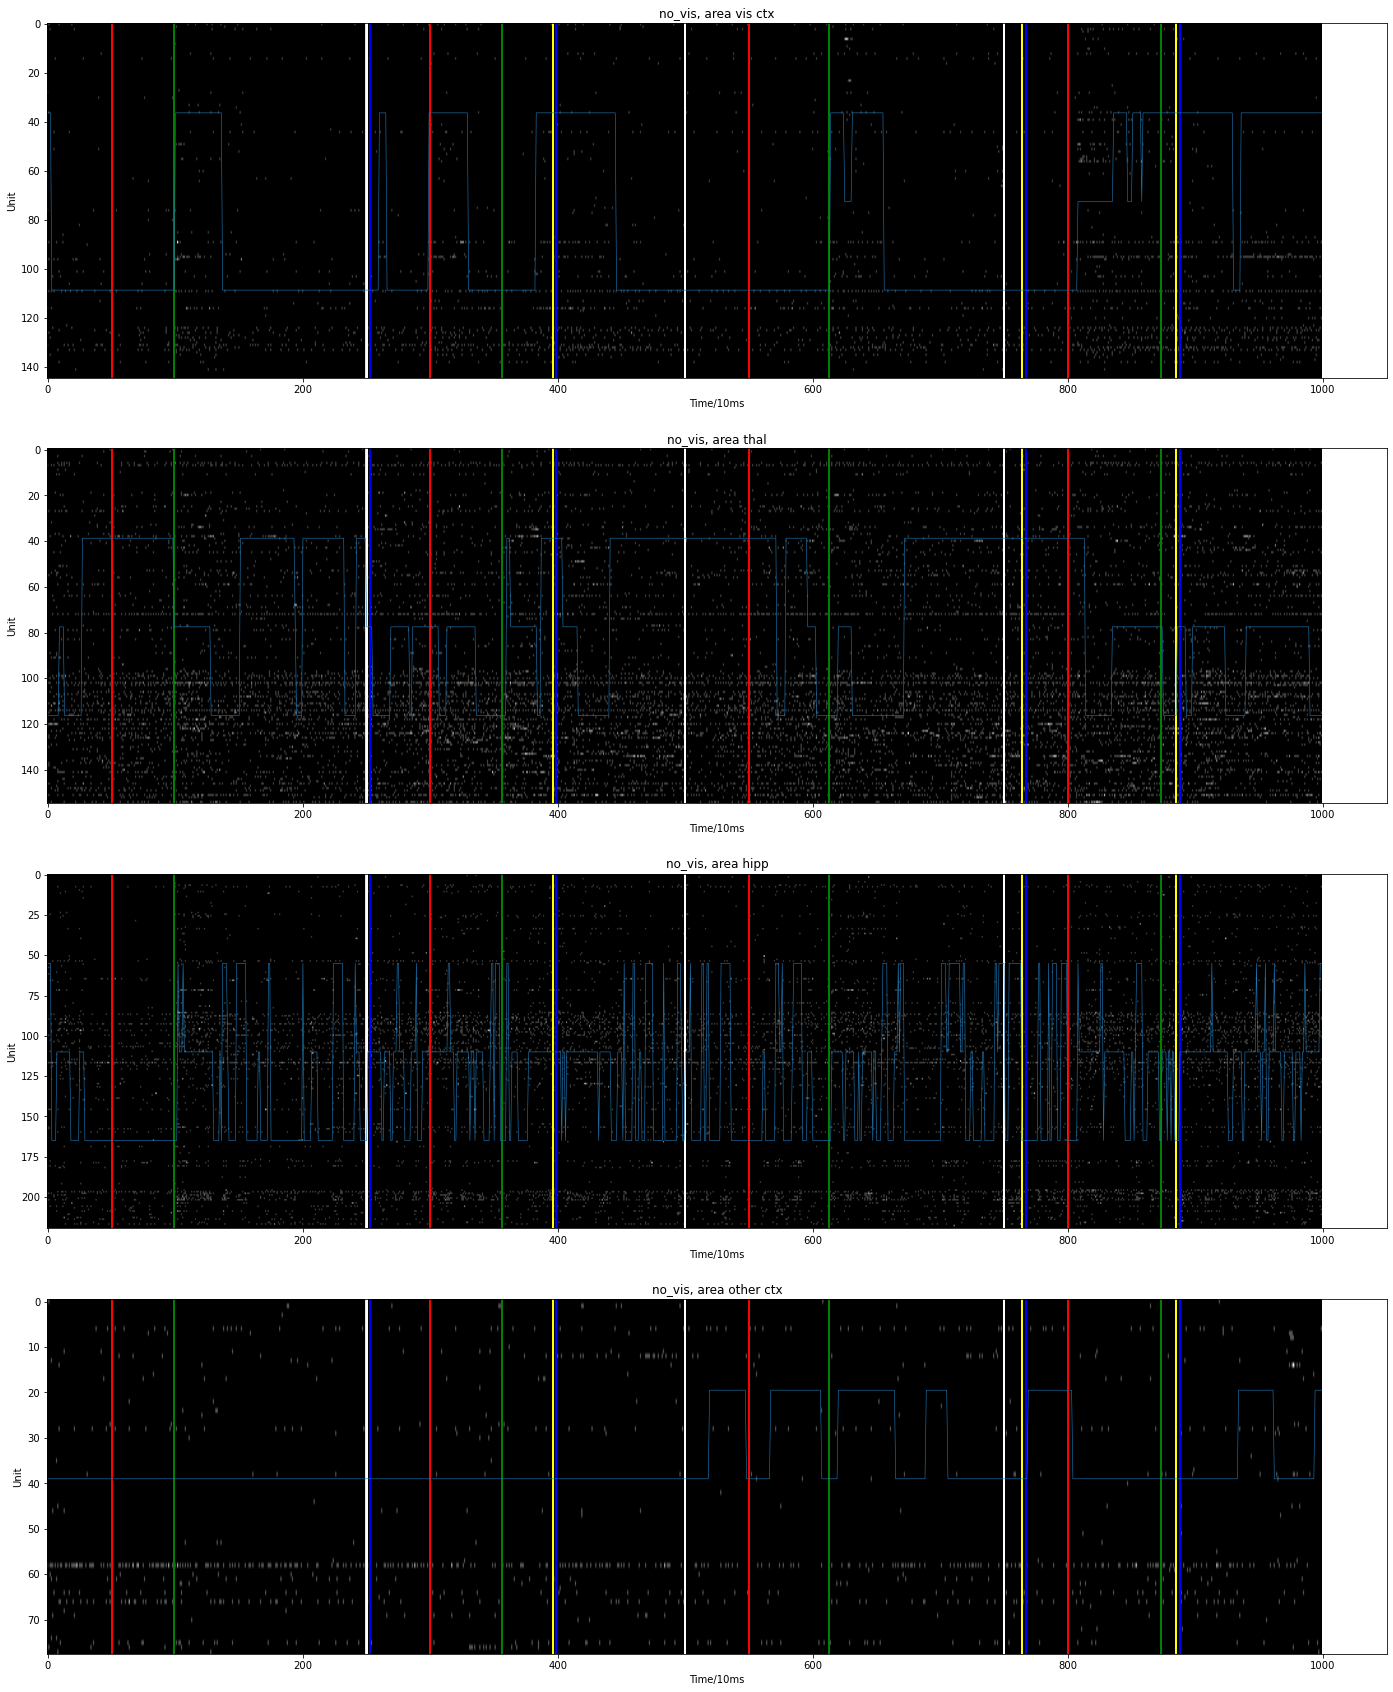

In [114]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['vis_left', 'no_vis', 'vis_right']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 30))

for i in range(nareas):

    neural_activity_vis_no = neural_activity[barea==i][:, vis_no_id, :]
    num_neurons = neural_activity_vis_no.shape[0]
    vis_no_input = neural_activity_vis_no.reshape(num_neurons, neural_activity_vis_no.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(vis_no_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(vis_no_input.T)
    
    vis_no_trial = vis_no_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(vis_no_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[vis_no_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[vis_no_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[vis_no_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*vis_no_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[1]}, area {regions[i]}')

plt.tight_layout
plt.show()

vis_right

LP: -78956.6: 100%|██████████| 300/300 [00:37<00:00,  7.94it/s]


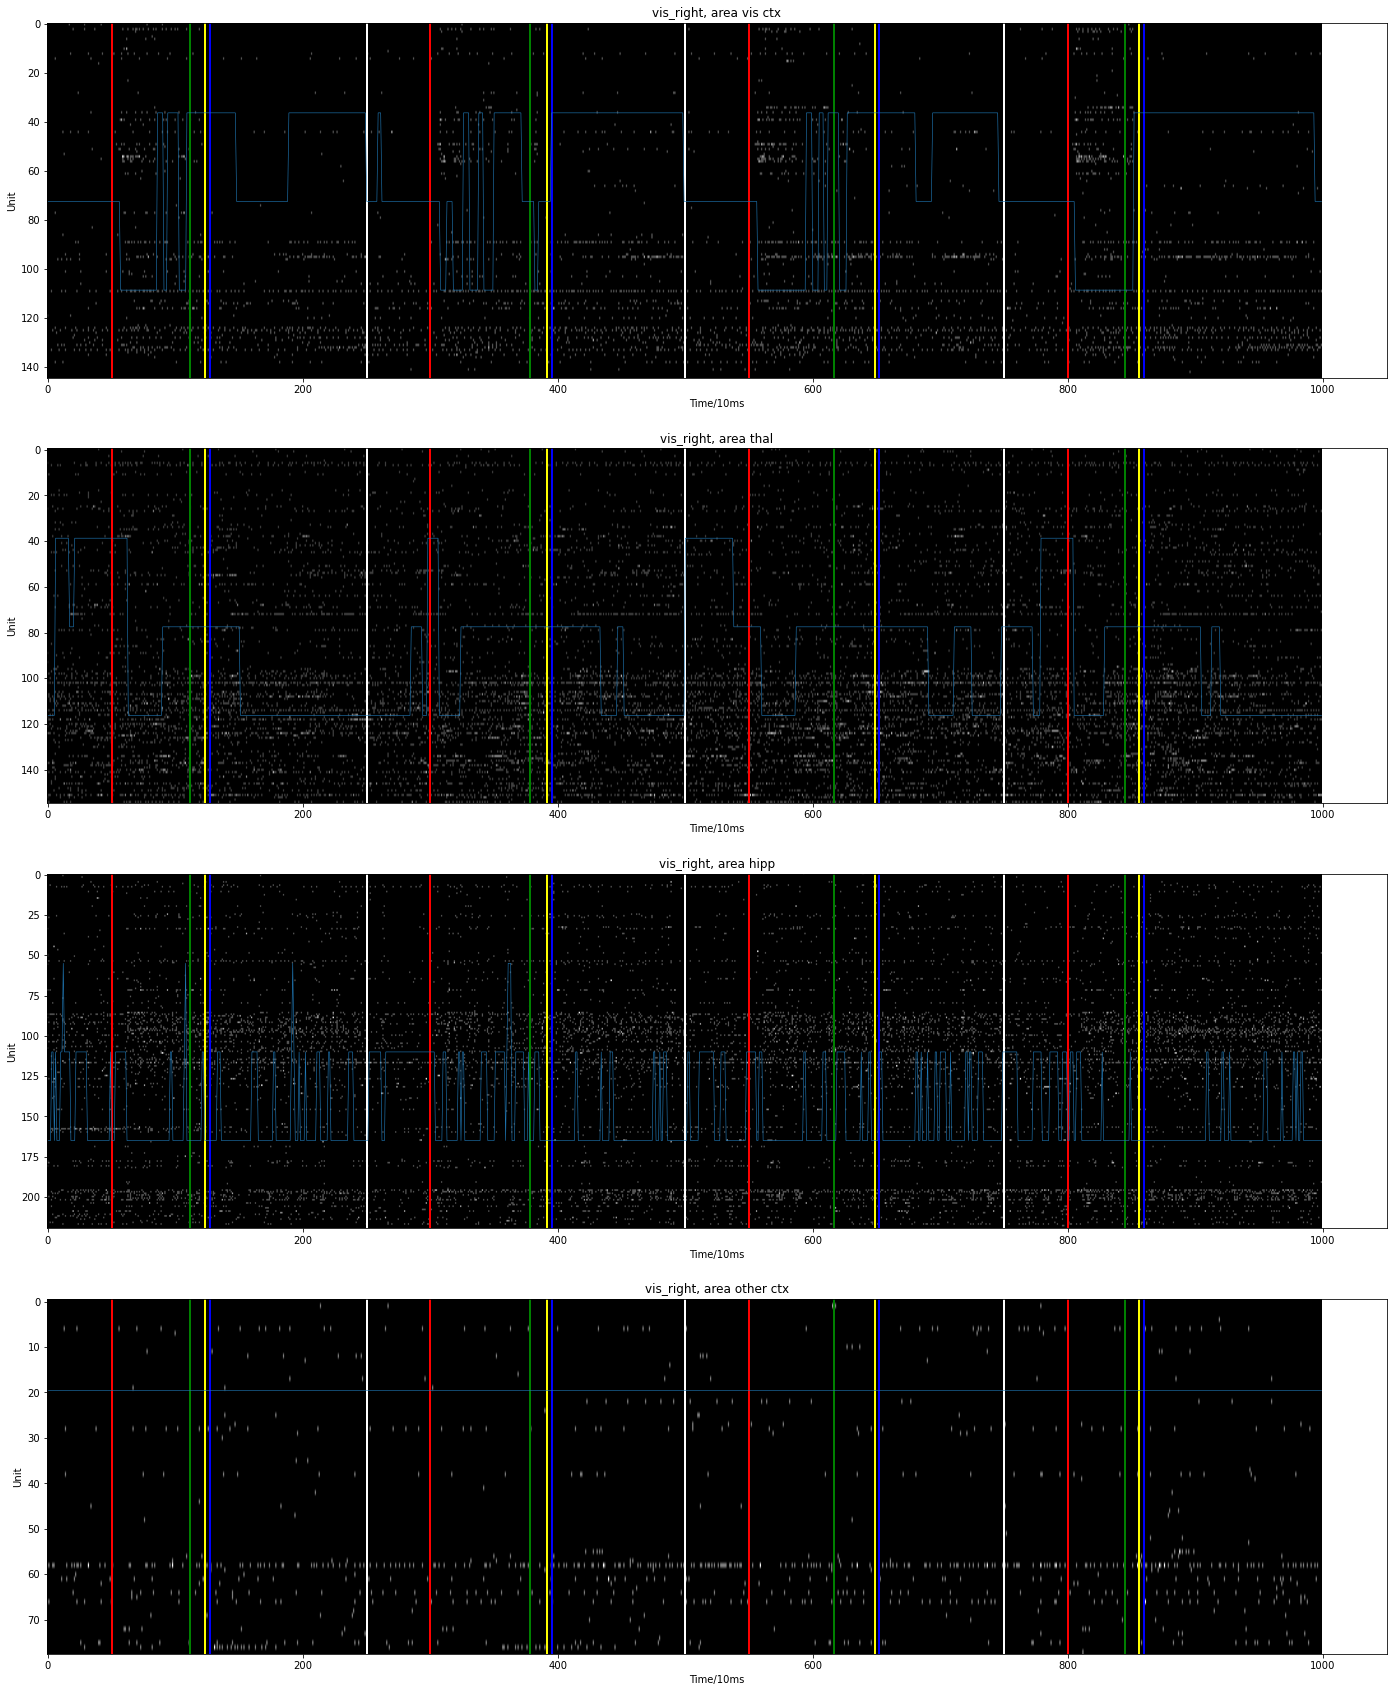

In [115]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['vis_left', 'no_vis', 'vis_right']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 30))

for i in range(nareas):

    neural_activity_vis_right = neural_activity[barea==i][:, vis_right_id, :]
    num_neurons = neural_activity_vis_right.shape[0]
    vis_right_input = neural_activity_vis_right.reshape(num_neurons, neural_activity_vis_right.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(vis_right_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(vis_right_input.T)
    
    vis_right_trial = vis_right_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(vis_right_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[vis_right_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[vis_right_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[vis_right_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*vis_right_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[2]}, area {regions[i]}')

plt.tight_layout
plt.show()

correct

LP: -122334.3: 100%|██████████| 300/300 [01:05<00:00,  4.61it/s]


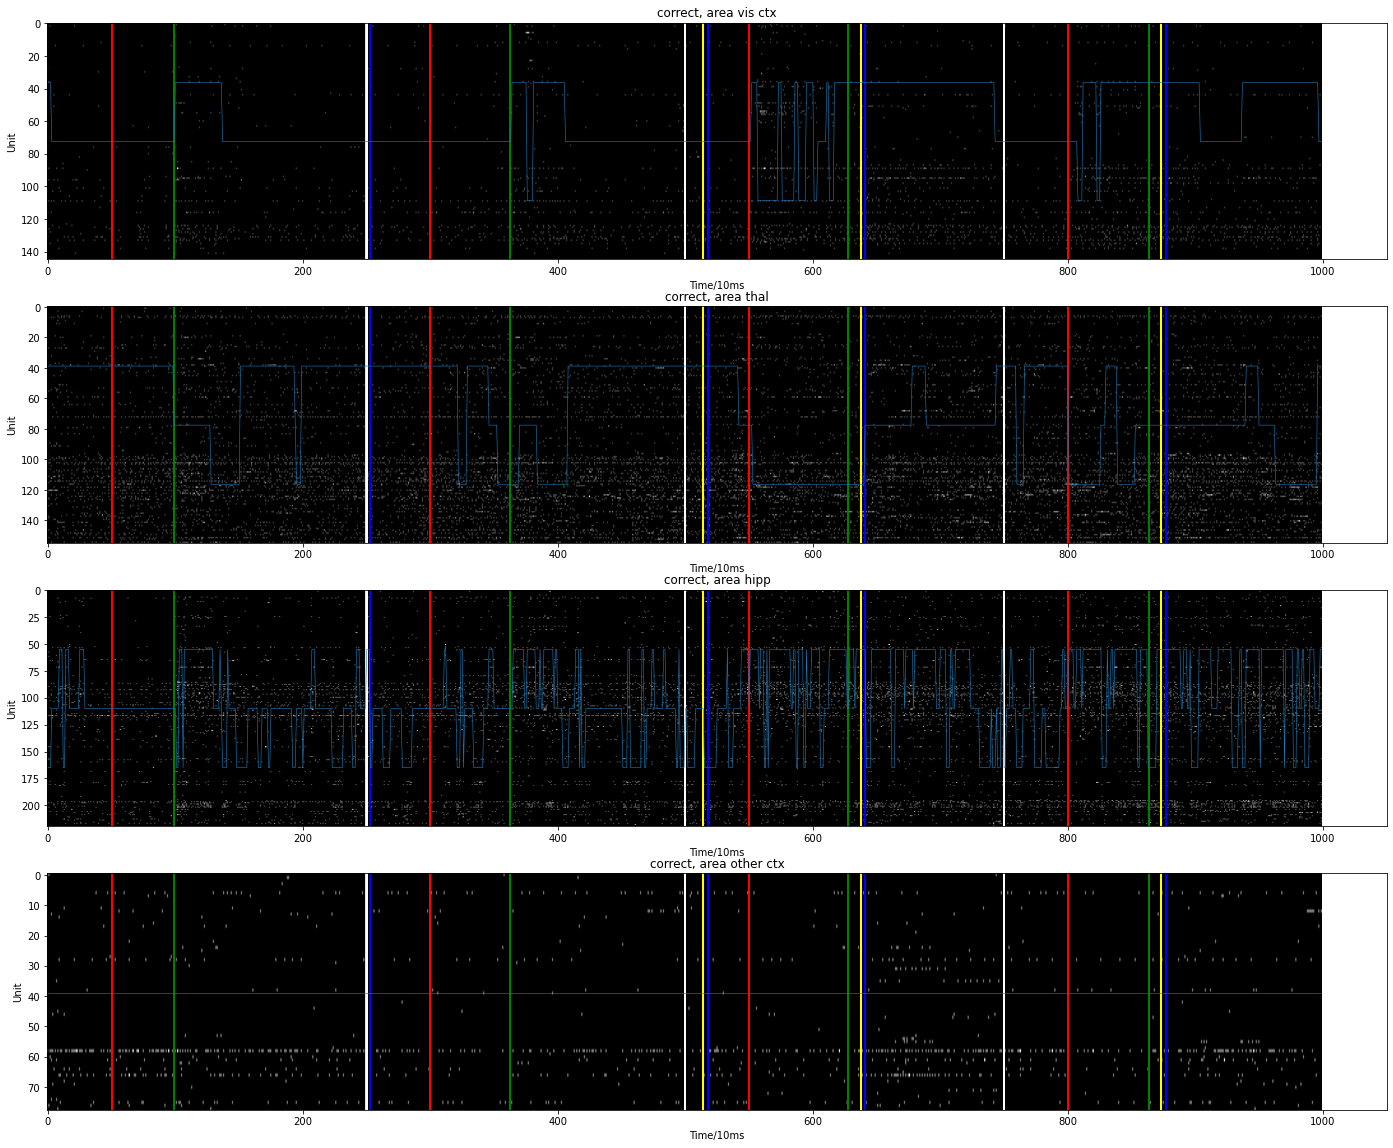

In [116]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['correct', 'incorrect']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 20))

for i in range(nareas):

    neural_activity_correct = neural_activity[barea==i][:, correct_id, :]
    num_neurons = neural_activity_correct.shape[0]
    correct_input = neural_activity_correct.reshape(num_neurons, neural_activity_correct.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(correct_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(correct_input.T)
    
    correct_trial = correct_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(correct_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[correct_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[correct_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[correct_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*correct_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[0]}, area {regions[i]}')

plt.tight_layout
plt.show()

incorrect

LP: -102794.5: 100%|██████████| 300/300 [00:54<00:00,  5.50it/s]


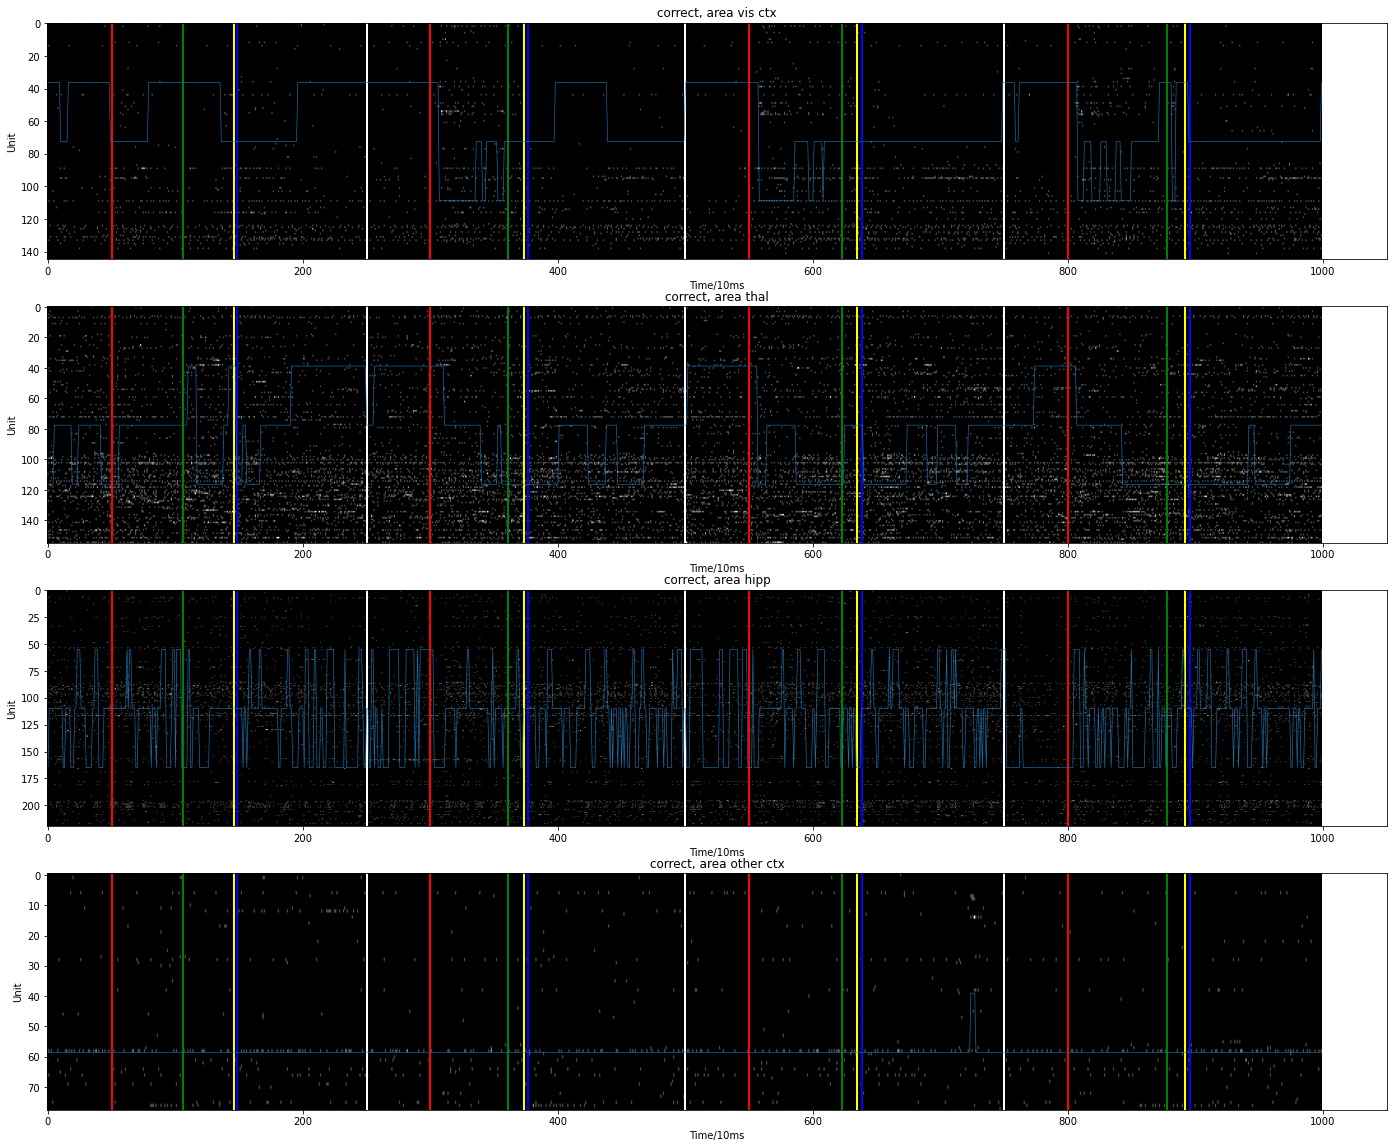

In [117]:
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['correct', 'incorrect']
f, axes = plt.subplots(nrows=nareas, figsize=(24, 20))

for i in range(nareas):

    neural_activity_incorrect = neural_activity[barea==i][:, incorrect_id, :]
    num_neurons = neural_activity_incorrect.shape[0]
    incorrect_input = neural_activity_incorrect.reshape(num_neurons, neural_activity_incorrect.shape[1]*time_bins)

    p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
    p_hmm.fit(incorrect_input.T, method="em", num_iters = 300)
    states_seq = p_hmm.most_likely_states(incorrect_input.T)
    
    incorrect_trial = incorrect_input[:, :n_trial*time_bins]
    states_seq_trial = states_seq[:n_trial*time_bins]

    axes[i].imshow(incorrect_trial, aspect='auto', cmap='gray')
    for j in range(n_trial):
        axes[i].axvline(x=stim_onset/bin_size+time_bins*j, color='red', linewidth=2, label='stim_onset')
        axes[i].axvline(x=gocue[incorrect_id][j]/bin_size+time_bins*j, color='green', linewidth=2, label='go_cue')
        axes[i].axvline(x=feedback_time[incorrect_id][j]/bin_size+time_bins*j, color='blue', linewidth=2, label='feedback_time')
        axes[i].axvline(x=response_time[incorrect_id][j]/bin_size+time_bins*j, color='yellow', linewidth=2, label='response_time')
        axes[i].axvline(x=time_bins*(j+1), color='white', linewidth=2, label='trial_time')

    axes[i].set_ylabel("Unit")
    axes[i].set_xlabel("Time/10ms")
    axes[i].plot((states_seq_trial+1)/(num_states+1)*incorrect_trial.shape[0], linewidth=0.6)
    axes[i].set_title(f'{trial_types[0]}, area {regions[i]}')

plt.tight_layout
plt.show()

Trial types by response

LP: -481733.7: 100%|██████████| 300/300 [01:25<00:00,  3.50it/s]


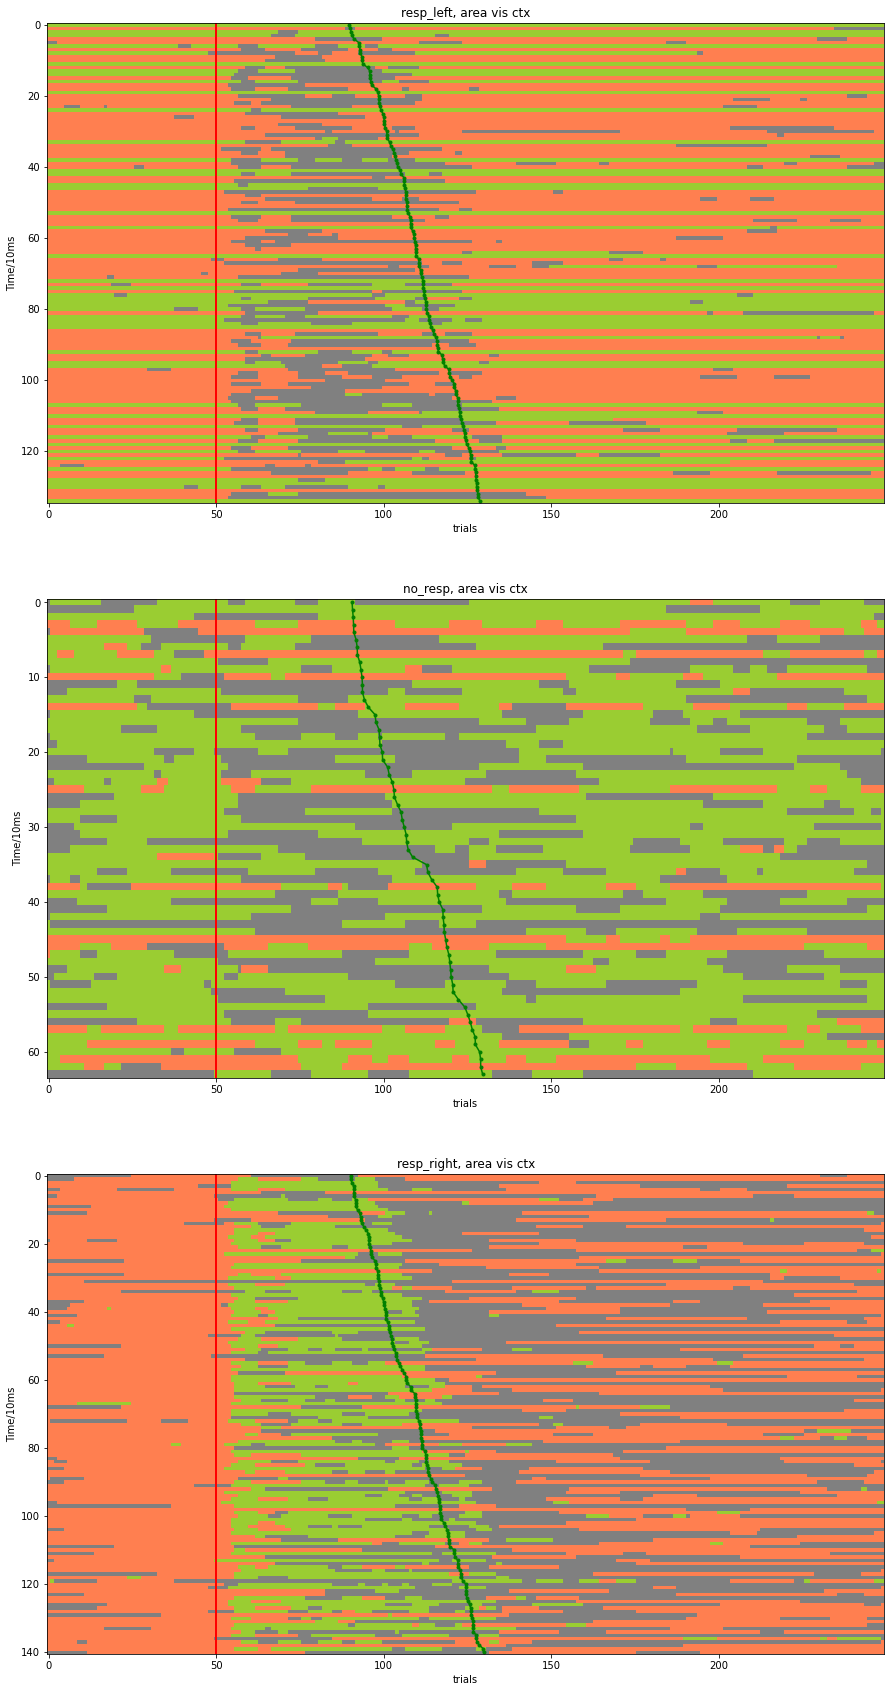

In [196]:
i_area = 0  
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=3, figsize=(15, 30))

# resp_left
neural_activity_resp_left = neural_activity[barea==i][:, resp_left_id, :]
neural_activity_resp_left = neural_activity[barea==i_area][:, resp_left_id, :]
num_neurons = neural_activity_resp_left.shape[0]
num_trials = neural_activity_resp_left.shape[1]
resp_left_input = neural_activity_resp_left.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_left_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_left_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_left_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# no_resp
neural_activity_resp_no = neural_activity[barea==i_area][:, resp_no_id, :]
num_neurons = neural_activity_resp_no.shape[0]
num_trials = neural_activity_resp_no.shape[1]
resp_no_input = neural_activity_resp_no.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_no_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_no_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_no_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

# resp_right
neural_activity_resp_right = neural_activity[barea==i_area][:, resp_right_id, :]
num_neurons = neural_activity_resp_right.shape[0]
num_trials = neural_activity_resp_right.shape[1]
resp_right_input = neural_activity_resp_right.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_right_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_right_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_right_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[2].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[2].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[2].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[2].set_ylabel("trials")
axes[2].set_xlabel("time_bins/10ms")
axes[2].set_title(f'{trial_types[2]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

Trial types by vis stimuli

LP: -406749.8: 100%|██████████| 300/300 [01:09<00:00,  4.35it/s]


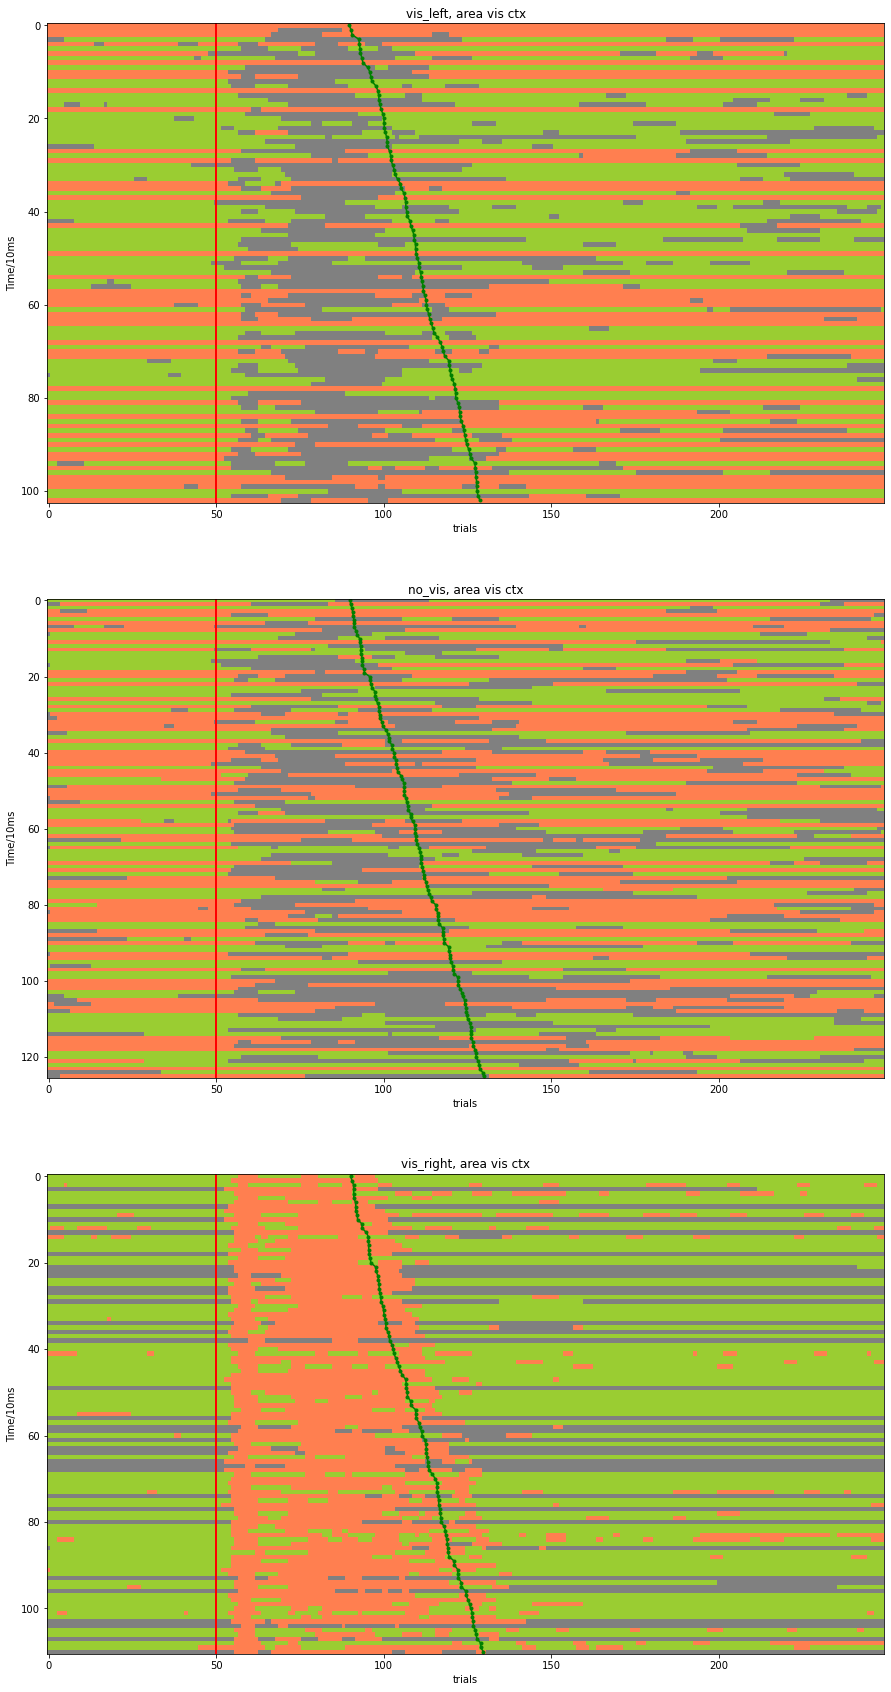

In [197]:
i_area = 0  
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['vis_left', 'no_vis', 'vis_right']
f, axes = plt.subplots(nrows=3, figsize=(15, 30))

#vis_left
neural_activity_vis_left = neural_activity[barea==i][:, vis_left_id, :]
neural_activity_vis_left = neural_activity[barea==i_area][:, vis_left_id, :]
num_neurons = neural_activity_vis_left.shape[0]
num_trials = neural_activity_vis_left.shape[1]
vis_left_input = neural_activity_vis_left.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_left_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_left_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_left_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# no_vis
neural_activity_vis_no = neural_activity[barea==i_area][:, vis_no_id, :]
num_neurons = neural_activity_vis_no.shape[0]
num_trials = neural_activity_vis_no.shape[1]
vis_no_input = neural_activity_vis_no.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_no_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_no_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_no_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

# vis_right
neural_activity_vis_right = neural_activity[barea==i_area][:, vis_right_id, :]
num_neurons = neural_activity_vis_right.shape[0]
num_trials = neural_activity_vis_right.shape[1]
vis_right_input = neural_activity_vis_right.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_right_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_right_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_right_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[2].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[2].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[2].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[2].set_ylabel("trials")
axes[2].set_xlabel("time_bins/10ms")
axes[2].set_title(f'{trial_types[2]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

trial types by results

LP: -539075.1: 100%|██████████| 300/300 [01:37<00:00,  3.07it/s]


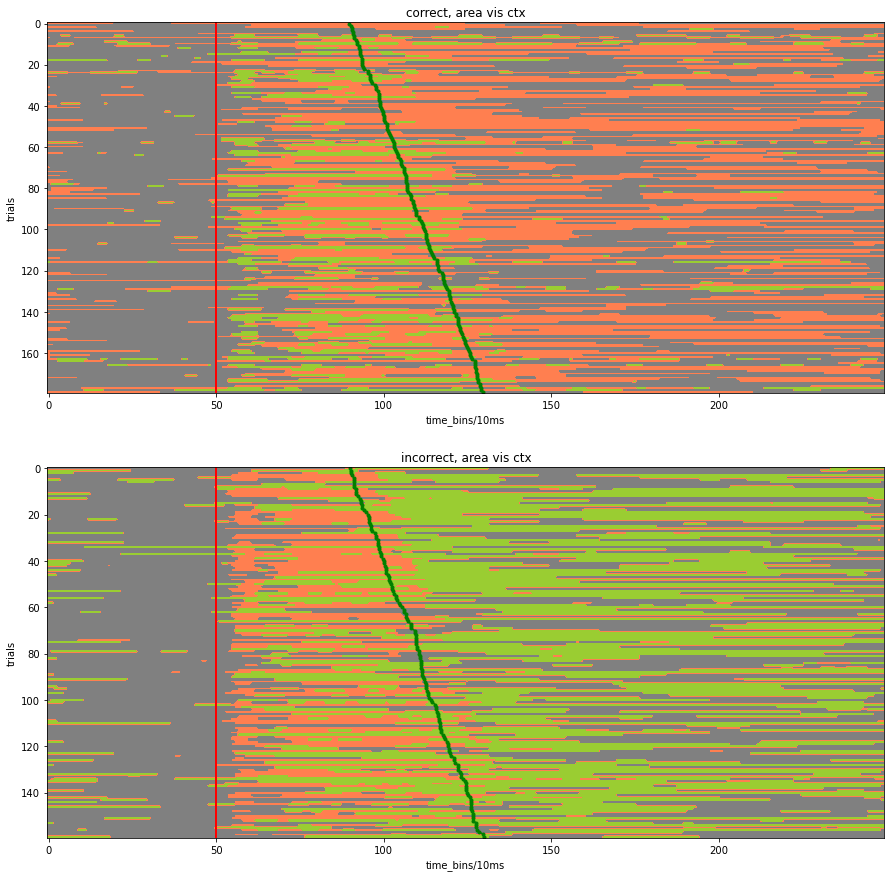

In [198]:
i_area = 0  
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['correct', 'incorrect']
f, axes = plt.subplots(nrows=2, figsize=(15, 15))

#correct
neural_activity_correct = neural_activity[barea==i][:, correct_id, :]
neural_activity_correct = neural_activity[barea==i_area][:, correct_id, :]
num_neurons = neural_activity_correct.shape[0]
num_trials = neural_activity_correct.shape[1]
correct_input = neural_activity_correct.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(correct_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(correct_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[correct_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# incorrect
neural_activity_incorrect = neural_activity[barea==i_area][:, incorrect_id, :]
num_neurons = neural_activity_incorrect.shape[0]
num_trials = neural_activity_incorrect.shape[1]
incorrect_input = neural_activity_incorrect.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(incorrect_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(incorrect_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[incorrect_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

# find best hidden states

In [ ]:
#Create kfold cross-validation object which will split data for us
nKfold = 5
kf = KFold(n_splits=nKfold, shuffle=True, random_state=None)

#Just for sanity's sake, let's check how it splits the data
#So 5-fold cross-validation uses 80% of the data to train the model, and holds 20% for testing
for ii, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
    print(f"kfold {ii} TRAIN:", len(train_index), "TEST:", len(test_index))
    
#10 different nnumber of latent states
#5-fold cross-validation
#That's 50 model fits! Thankfully this can be parallelized fairly easily
max_states = 10
ll_training = np.zeros((max_states,nKfold))
ll_heldout = np.zeros((max_states,nKfold))
BIC_heldout = np.zeros((max_states,nKfold))

hmm_z_ms = np.zeros((max_states,time_bins))
#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(range(1,max_states+1)):
    #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
    K = num_states*num_states + num_states*obs_dim + num_states*obs_dim
    
    #Inner loop over kfolds
    for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
        nTrain = len(train_index); nTest = len(test_index)#*obs_dim
        
        #Split data
        training_data = synthetic_data[train_index]
        test_data = synthetic_data[test_index]
        
        #Create HMM object to fit
        hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

        #fit on training data
        hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")
        
        #Compute log-likelihood for each dataset
        ll_training[iS,iK] = hmm.log_probability(training_data)/nTrain
        ll_heldout[iS,iK] = hmm.log_probability(test_data)/nTest
        
        #Let's calculate the BIC as well for this
        BIC_heldout[iS,iK] = K*np.log(nTest) - 2*hmm.log_probability(test_data)
        
    #Let's do a full model fit and get the state-sequence
    hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
    hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters)
    most_likely_states = hmm.most_likely_states(synthetic_data)
    
    hmm_z_ms[iS,:] = hmm.most_likely_states(synthetic_data)

# Plot statistical features

# align the trial event time

In [41]:
num_states = 3
num_neurons = neural_activity.shape[0]

# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0, 0]))

# Manually initialize the means for each state
lambdas_before_onset = np.mean(neural_activity[:, n_trial, :stim_onset], axis=(0, 1))
lambdas_onset_response = np.mean(neural_activity[:, n_trial, stim_onset:int(response_time[1])], axis=(0, 1))
lambdas_after_response = np.mean(neural_activity[:, n_trial, int(response_time[1]):], axis=(0, 1))

lambdas = np.vstack((lambdas_before_onset,
                     lambdas_onset_response,
                     lambdas_after_response))

# Manually initialize the transition probabilities
A = np.array(
[[0.8, 0.1, 0],
[0, 0.9, 0.1],
[0, 0, 1]]
)

# Create our HMM
transition_mask = (A > 0)
transition_kwargs = {"transition_mask": transition_mask}
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="constrained",
                     init_state_distn=init_dist,
                     transition_kwargs=transition_kwargs)

d:\download_files\Anaconda_app\anaconda_files\envs\env_py_36\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [43]:
datas = []
for i in range(neural_activity.shape[1]):
    spikes_cur = np.squeeze(neural_activity[:, i, :])

    # Transpose the data for passing to SSM fit function
    # To use the Poisson observation model, we must also
    # convert our arrays to be integer types.
    datas.append(np.asarray(spikes_cur.T, dtype=int))

In [44]:
simple_hmm.log_lambdas = np.log(lambdas)
simple_hmm.transitions.log_Ps = np.log(A)
lls = simple_hmm.fit(datas, method='em')

d:\download_files\Anaconda_app\anaconda_files\envs\env_py_36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
LP: -7959330.1: 100%|██████████| 100/100 [06:36<00:00,  3.96s/it]


In [51]:
# Plot the true and inferred discrete states
hmm_z = simple_hmm.most_likely_states(np.array(datas))

ValueError: operands could not be broadcast together with shapes (340,1,250,698) (3,698) 

In [49]:
hmm_z 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

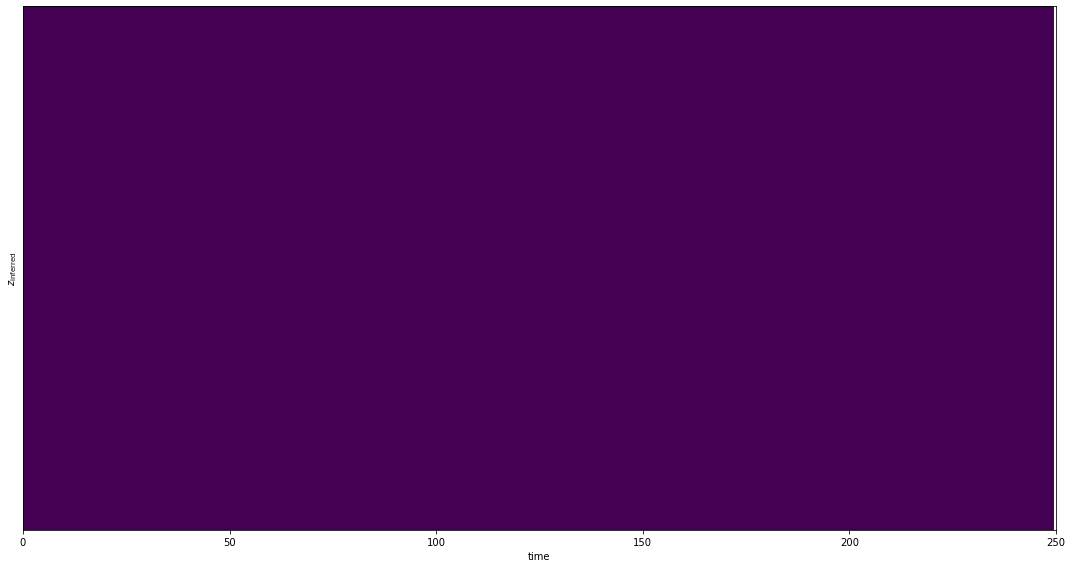

In [48]:
plt.figure(figsize=(15,8))

plt.imshow(hmm_z[None,:], aspect="auto")
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()